# Title I Allocations w/ DP ACS

In [1]:
from dp_policy.api import titlei_funding as funding
from dp_policy.titlei.allocators import AbowdAllocator, SonnenbergAuthorizer
from dp_policy.titlei.utils import weighting
from dp_policy.titlei.mechanisms import Laplace, Gaussian, GroundTruth
from dp_policy.titlei.utils import get_saipe
from dp_policy.titlei.utils import get_sppe
from dp_policy.api import titlei_data as data

import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from tqdm.notebook import tqdm
import pandas as pd
import pickle
import shapefile as shp
import geopandas as gpd
import seaborn as sns

saipe = get_saipe("../data/saipe19.xls")

%matplotlib inline
%load_ext autoreload
%autoreload 2

## Allocation Algorithm

### Data
Need state per-pupil expenditure (SPPE) from the NCES. Most recent I can find in <5min is the [FY '18 data](https://nces.ed.gov/pubsearch/pubsinfo.asp?pubid=2020308).

Had to use an online tool to convert Table 2 of [this report](https://nces.ed.gov/pubs2020/2020308.pdf).

In [2]:
sppe = get_sppe("../data/sppe18.xlsx")
sppe.head()

state    ppe abbrv
0         Alabama   9697    AL
1          Alaska  17726    AK
2  American Samoa    NaN    AS
3         Arizona   8296    AZ
4        Arkansas  10072    AR

Also need a dict matching district IDs to district names to states. Simplest to use [SAIPE 2019](https://www2.census.gov/programs-surveys/saipe/datasets/2019/2019-school-districts/) ground-truth.

Also, a method for roughly estimating standard errors for the SAIPE estimates, based on [these published docs](https://www.census.gov/programs-surveys/saipe/guidance/district-estimates.html). This could be improved - but start with this as a shortcut.

In [3]:
saipe = get_saipe("../data/saipe19.xls")
saipe.head()

State Postal Code  \
State FIPS Code District ID                     
1               190                        AL   
                5                          AL   
                30                         AL   
                60                         AL   
                90                         AL   

                                                            Name  \
State FIPS Code District ID                                        
1               190               Alabaster City School District   
                5               Albertville City School District   
                30           Alexander City City School District   
                60                Andalusia City School District   
                90                 Anniston City School District   

                             Estimated Total Population  \
State FIPS Code District ID                               
1               190                               34669   
                5                                 22051   
                30                                16920   
                60                                 8842   
                90                                22043   

                             Estimated Population 5-17  \
State FIPS Code District ID                              
1               190                               6710   
                5                                 4131   
                30                                2575   
                60                                1465   
                90                                3065   

                             Estimated number of relevant children 5 to 17 years old in poverty who are related to the householder  \
State FIPS Code District ID                                                                                                          
1               190                                                        649                                                       
                5                                                          957                                                       
                30                                                         703                                                       
                60                                                         406                                                       
                90                                                        1057                                                       

                               cv  
State FIPS Code District ID        
1               190          0.23  
                5            0.23  
                30           0.28  
                60           0.35  
                90           0.23

In [4]:
# average school district student pop
saipe["Estimated Population 5-17"].mean()
saipe["Estimated number of relevant children 5 to 17 years old in poverty who are related to the householder"].mean()

645.2559921116505

### Code

Next, a class for the different ways we might allocate funds based on the poverty estimates (e.g. Abowd's shortcut method vs. the full Sonnenberg method).

Finally, the main method for computing estimates, then grant amounts.

[WARN] Dropping districts with missing SPPE data: ['Puerto Rico']
136021116192.56747 authorized reducedto 15999020221.602928 allocated.
136021116192.56747 authorized reducedto 15999020221.602928 allocated.


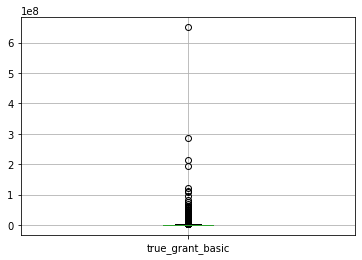

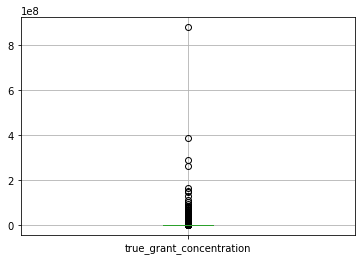

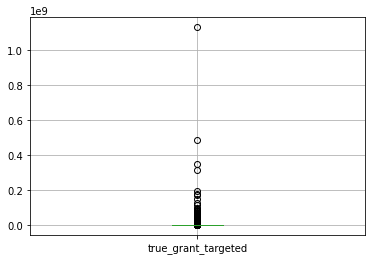

In [6]:
import numpy as np
import matplotlib.pyplot as plt

from dp_policy.api import titlei_funding as funding

# Test with ground truth mechanism
grants = funding(SonnenbergAuthorizer, saipe, GroundTruth(saipe), get_sppe("../data/sppe18.xlsx"))
grants.boxplot('true_grant_basic')
plt.show()
grants.boxplot('true_grant_concentration')
plt.show()
grants.boxplot('true_grant_targeted')
plt.show()

## Hold harmless provision - optional

In [4]:
saipe = get_saipe("../data/saipe19.xls")
grants = funding(SonnenbergAuthorizer, saipe, GroundTruth(saipe), get_sppe("../data/sppe18.xlsx"))
grants_hold = funding(SonnenbergAuthorizer, saipe, GroundTruth(saipe), get_sppe("../data/sppe18.xlsx"), allocator_kwargs={'hold_harmless': True})

[WARN] Dropping districts with missing SPPE data: ['Puerto Rico']
136021116192.56747 authorized reducedto 15999020221.602928 allocated.
136021116192.56747 authorized reducedto 15999020221.602928 allocated.
[WARN] Dropping districts with missing SPPE data: ['Puerto Rico']
136021116192.56747 authorized reducedto 15999020221.602928 allocated.
136021116192.56747 authorized reducedto 15999020221.602928 allocated.
Holding harmless


ValueError: invalid literal for int() with base 10: 'EA ID'

## Laplace
### Data
From [SAIPE 2019](https://www2.census.gov/programs-surveys/saipe/datasets/2019/2019-school-districts/) release.

### Mechanism

In [5]:
from dp_policy.titlei.mechanisms import Laplace
        
Laplace(saipe, 0.1, 0).poverty_estimates()

(State FIPS Code  District ID
 1                190              34676.0
                  5                22098.0
                  30               16885.0
                  60                8828.0
                  90               22081.0
                                   ...    
 56               6240              7061.0
                  5820               681.0
                  4830              5474.0
                  6090              1483.0
 72               30             3193749.0
 Name: Estimated Total Population, Length: 13184, dtype: float64,
 State FIPS Code  District ID
 1                190              6711.0
                  5                4119.0
                  30               2594.0
                  60               1475.0
                  90               3028.0
                                   ...   
 56               6240             1282.0
                  5820               64.0
                  4830              812.0
                  6090 

### Results
First, using the full Sonnenberg authorization algo.

3 iters:


trial:   0%|          | 0/1 [00:00<?, ?it/s]

delta:   0%|          | 0/1 [00:00<?, ?it/s]

eps:   0%|          | 0/3 [00:00<?, ?it/s]

(0.1, 1.0, 5.0)
## basic grants ##
RMSE at eps=0.1: 59166.57008651224
RMSE prop eps=0.1: 0.033031222871493064
Total misalloc at eps=0.1: 528467202.66529053
Total true alloc: 15999020221.602888
## concentration grants ##
RMSE at eps=0.1: 230771.29277819482
RMSE prop eps=0.1: 0.0496326062602678
Total misalloc at eps=0.1: 794073071.2089324
Total true alloc: 15999020221.602951
## targeted grants ##
RMSE at eps=0.1: 101765.55983391848
RMSE prop eps=0.1: 0.03539733574032708
Total misalloc at eps=0.1: 566322690.3003702
Total true alloc: 15999020221.60294
## total grants ##
RMSE at eps=0.1: 95446.30717488485
RMSE prop eps=0.1: 0.03755666257726871
Total misalloc at eps=0.1: 600869804.0296566
Total true alloc: 15999020221.60297


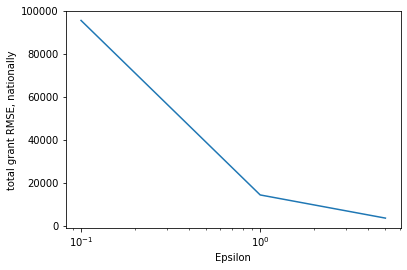

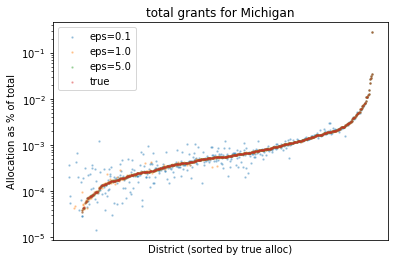

<ipython-input-64-15163c4e8869>:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  alloc['err_prop'] = (alloc[f"est_grant_{grant_type}"]/sum(alloc[f"est_grant_{grant_type}"]) - alloc[f"true_grant_{grant_type}"]/sum(alloc[f"true_grant_{grant_type}"])) * 1e6


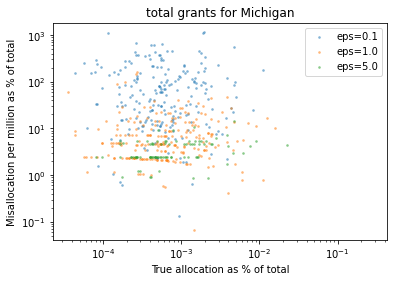

In [64]:
import itertools
from dp_policy.titlei.allocators import Allocator

def test_params(saipe, mech, eps=list(np.logspace(-3, 1)) + [2.5], delta=[0.0], trials = 1, mech_kwargs={}, auth=False):
    allocations = []
    print(f"{len(eps)*len(delta)*trials} iters:")
    for trial in tqdm(range(trials), desc='trial'):
        for d in tqdm(delta, desc='delta', leave=False):
            for e in tqdm(eps, desc='eps', leave=False):
                allocations.append(funding(
                    SonnenbergAuthorizer,
                    saipe,  
                    mech(saipe, e, d, **mech_kwargs), 
                    get_sppe("../data/sppe18.xlsx"), 
                    verbose=False,
                    uncertainty=False,
                    normalize = not auth
                ))
    return pd.concat(
        allocations, axis=0,
        keys=itertools.product(range(trials), delta, eps), 
        names=["trial", "delta", "epsilon"] + list(allocations[-1].index.names)
    )

calc_total = SonnenbergAuthorizer.calc_total

def plot_results(results, delta=False):
    
    eps, allocations = list(zip(*results.groupby("epsilon")))
    print(eps)
    
    mse = []
    
    for e, alloc in results.groupby("epsilon"):
        for grant_type in ("basic", "concentration", "targeted", "total"):
            error = alloc[f"true_grant_{grant_type}"] - alloc[f"est_grant_{grant_type}"]
            error_prop = alloc[f"true_grant_{grant_type}"]/sum(alloc[f"true_grant_{grant_type}"])\
                - alloc[f"est_grant_{grant_type}"]/sum(alloc[f"est_grant_{grant_type}"])
            if (e == 2.52) or (e == 0.1):
                print(f"## {grant_type} grants ##")
                print(f"RMSE at eps={e}:", np.sqrt(np.mean(error**2)))
                print(f"RMSE prop eps={e}:", sum(abs(error_prop)))
                print(f"Total misalloc at eps={e}:", sum(abs(error)))
                print("Total true alloc:", sum(alloc[f"true_grant_{grant_type}"]))
        
            if grant_type == "total":
                mse.append(np.sqrt(sum(error**2)/alloc.shape[0]))
    
    grant_type = "total"
    plt.plot(eps, mse)
    ax = plt.gca()
    ax.set_xscale('log')
    plt.xlabel("Epsilon")
    plt.ylabel(f"{grant_type} grant RMSE, nationally")
    plt.show()

    for i in range(len(eps)):
        e = eps[i]
        alloc = allocations[i][allocations[i]["State Postal Code"] == "MI"]
        alloc = alloc.sort_values(f"true_grant_{grant_type}")
        plt.scatter(range(len(alloc)), alloc[f"est_grant_{grant_type}"]/sum(alloc[f"est_grant_{grant_type}"]), s=2, alpha=0.3, label=f"eps={e}")
    plt.scatter(range(len(alloc)), alloc[f"true_grant_{grant_type}"]/sum(alloc[f"true_grant_{grant_type}"]), s=2, alpha=0.3, label="true")
    ax = plt.gca()
    ax.legend()
    ax.axes.xaxis.set_ticks([])
    ax.set_yscale('log')
    plt.xlabel("District (sorted by true alloc)")
    plt.ylabel("Allocation as % of total")
    plt.title(f"{grant_type} grants for Michigan")
    plt.show()

    for i in range(len(eps)):
        e = eps[i]
        alloc = allocations[i][allocations[i]["State Postal Code"] == "MI"]
        alloc['err_prop'] = (alloc[f"est_grant_{grant_type}"]/sum(alloc[f"est_grant_{grant_type}"]) - alloc[f"true_grant_{grant_type}"]/sum(alloc[f"true_grant_{grant_type}"])) * 1e6
        plt.scatter(alloc[f"true_grant_{grant_type}"]/sum(alloc[f"true_grant_{grant_type}"]), alloc.err_prop, s=3, alpha=0.4, label=f"eps={e}")
    ax = plt.gca()
    ax.legend()
    ax.set_xscale('log')
    ax.set_yscale('log')
    plt.xlabel("True allocation as % of total")
    plt.ylabel("Misallocation per million as % of total")
    plt.title(f"{grant_type} grants for Michigan")
    plt.show()

plot_results(test_params(saipe, Laplace, eps=[0.1, 1.0, 5.0], delta=[0.0]))

In [65]:
results = test_params(saipe, Laplace, eps=[0.1, 1.0, 2.52, 10.0], mech_kwargs={'round': False}, auth=True)
results.to_csv("../results/titlei_laplace.csv")

4 iters:


trial:   0%|          | 0/1 [00:00<?, ?it/s]

delta:   0%|          | 0/1 [00:00<?, ?it/s]

eps:   0%|          | 0/4 [00:00<?, ?it/s]

(0.1, 1.0, 2.52, 10.0)
## basic grants ##
RMSE at eps=0.1: 139573.7665140945
RMSE prop eps=0.1: 0.032308390518523265
Total misalloc at eps=0.1: 1272810915.354346
Total true alloc: 39875386755.81138
## concentration grants ##
RMSE at eps=0.1: 369316.04399375606
RMSE prop eps=0.1: 0.0506715737072481
Total misalloc at eps=0.1: 1333675867.201677
Total true alloc: 29419819933.748734
## targeted grants ##
RMSE at eps=0.1: 283353.7532695844
RMSE prop eps=0.1: 0.034734398192262324
Total misalloc at eps=0.1: 2145948458.5852115
Total true alloc: 66725909503.0075
## total grants ##
RMSE at eps=0.1: 641094.4300067239
RMSE prop eps=0.1: 0.037180320596439845
Total misalloc at eps=0.1: 4747233352.495224
Total true alloc: 136021116192.56728
## basic grants ##
RMSE at eps=2.52: 12800.562945172114
RMSE prop eps=2.52: 0.001401353525865563
Total misalloc at eps=2.52: 55593628.06831781
Total true alloc: 39875386755.81138
## concentration grants ##
RMSE at eps=2.52: 65162.825370324215
RMSE prop eps=2.52: 0.

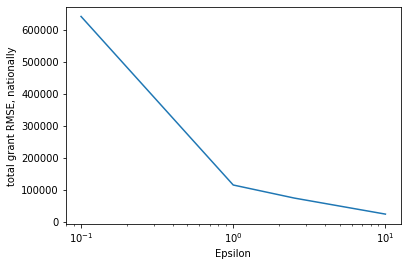

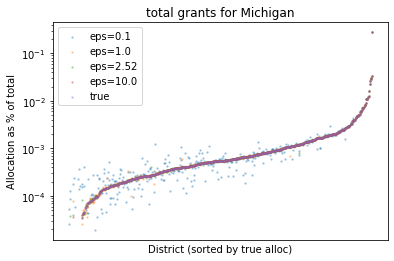

<ipython-input-64-15163c4e8869>:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  alloc['err_prop'] = (alloc[f"est_grant_{grant_type}"]/sum(alloc[f"est_grant_{grant_type}"]) - alloc[f"true_grant_{grant_type}"]/sum(alloc[f"true_grant_{grant_type}"])) * 1e6


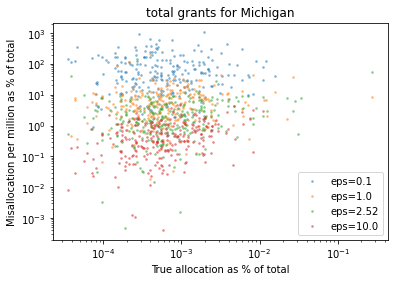

In [66]:
results = pd.read_csv("../results/titlei_laplace.csv").set_index(["epsilon", "State FIPS Code", "District ID"])
plot_results(results)

### Sanity check: using Abowd's method

Abowd reported a mean squared SPPE of 20 million from 2014-15 data.

In [29]:
grants = funding(AbowdAllocator, saipe, Laplace(saipe, 2.52, 0, sensitivity=2.0), get_sppe("../data/sppe18.xlsx"))
print("Mean Sq. SPPE (2018):", np.mean(grants.adj_sppe**2))

[WARN] Dropping districts with missing SPPE data: ['Puerto Rico']
Mean Sq. SPPE (2018): 26235395.69087739


They also report an RMSE at e=2.52 of 2509 (again, using 2014-15 Common Core data, which I can't replicate) and 1334 at e=4.74 and 63000 at e=0.1. 

In [30]:
# RMSE
error = grants.true_grant_total - grants.est_grant_total
np.sqrt(np.mean(error**2))

5891.298284310475

In [31]:
print("Total misalloc at eps=2.52:", sum(abs(error)))

Total misalloc at eps=2.52: 49039875.38971276


In [32]:
grants = funding(AbowdAllocator, saipe, Laplace(saipe, 4.74, 0), get_sppe("../data/sppe18.xlsx"))
error = grants.true_grant_total - grants.est_grant_total
np.sqrt(np.mean(error**2))

[WARN] Dropping districts with missing SPPE data: ['Puerto Rico']


3257.1610922211535

In [33]:
grants = funding(AbowdAllocator, saipe, Laplace(saipe, 0.1, 0), get_sppe("../data/sppe18.xlsx"))
error = grants.true_grant_total - grants.est_grant_total
np.sqrt(np.mean(error**2))

[WARN] Dropping districts with missing SPPE data: ['Puerto Rico']


139341.4248355362

So we get some small differences due to inflation or due to other differences in data, but roughly the same values. Biggest difference is in SPPE - apparenlty spending has increased since 2014.

## Gaussian (Advanced Composition, Approx. DP)

Add Gaussian noise ln(1/delta)/epsilon for better accuracy bound.

In [87]:
from dp_policy.titlei.mechanisms import Gaussian

# with delta = 0
results = test_params(
    saipe,
    Gaussian, 
    delta=list(np.linspace(1e-8, 1e-5, endpoint=False, num=10)),
    auth=False
)
results.to_csv("../results/titlei_gaussian.csv")

510 iters:


trial:   0%|          | 0/1 [00:00<?, ?it/s]

delta:   0%|          | 0/10 [00:00<?, ?it/s]

eps:   0%|          | 0/51 [00:00<?, ?it/s]

eps:   0%|          | 0/51 [00:00<?, ?it/s]

eps:   0%|          | 0/51 [00:00<?, ?it/s]

eps:   0%|          | 0/51 [00:00<?, ?it/s]

eps:   0%|          | 0/51 [00:00<?, ?it/s]

eps:   0%|          | 0/51 [00:00<?, ?it/s]

eps:   0%|          | 0/51 [00:00<?, ?it/s]

eps:   0%|          | 0/51 [00:00<?, ?it/s]

eps:   0%|          | 0/51 [00:00<?, ?it/s]

eps:   0%|          | 0/51 [00:00<?, ?it/s]

In [88]:
results = pd.read_csv("../results/titlei_gaussian.csv").set_index(['delta', 'epsilon', 'State FIPS Code', 'District ID'])

2.008e-06
(0.001, 0.0012067926406393, 0.0014563484775012, 0.0017575106248547, 0.0021209508879201, 0.0025595479226995, 0.0030888435964774, 0.0037275937203149, 0.0044984326689694, 0.0054286754393238, 0.0065512855685955, 0.0079060432109077, 0.0095409547634999, 0.0115139539932644, 0.0138949549437313, 0.01676832936811, 0.0202358964772515, 0.0244205309454865, 0.029470517025518, 0.0355648030622312, 0.0429193426012877, 0.0517947467923121, 0.0625055192527397, 0.0754312006335461, 0.0910298177991521, 0.1098541141987558, 0.1325711365590108, 0.1599858719606057, 0.1930697728883249, 0.2329951810515372, 0.2811768697974228, 0.3393221771895326, 0.4094915062380423, 0.4941713361323833, 0.5963623316594643, 0.7196856730011514, 0.868511373751352, 1.0481131341546852, 1.2648552168552958, 1.5264179671752318, 1.8420699693267144, 2.2229964825261934, 2.5, 2.682695795279725, 3.2374575428176438, 3.906939937054613, 4.714866363457389, 5.689866029018293, 6.866488450042998, 8.286427728546842, 10.0)


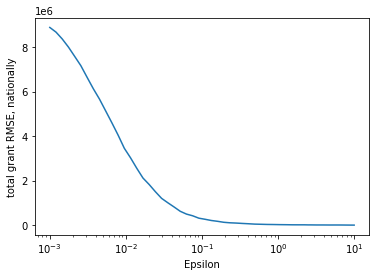

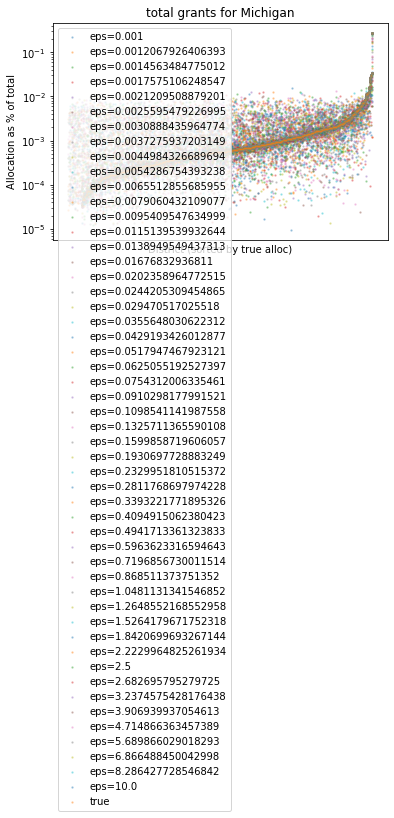

<ipython-input-64-15163c4e8869>:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  alloc['err_prop'] = (alloc[f"est_grant_{grant_type}"]/sum(alloc[f"est_grant_{grant_type}"]) - alloc[f"true_grant_{grant_type}"]/sum(alloc[f"true_grant_{grant_type}"])) * 1e6


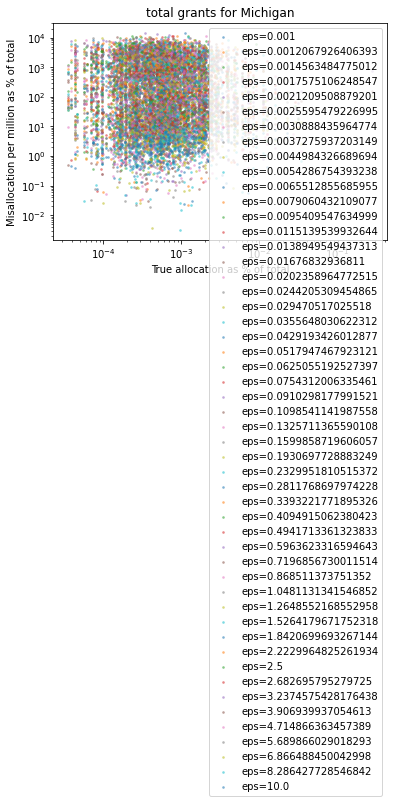

In [89]:
print(results.index.get_level_values('delta').unique()[2])
plot_results(results.xs(results.index.get_level_values('delta').unique()[2], level='delta'))

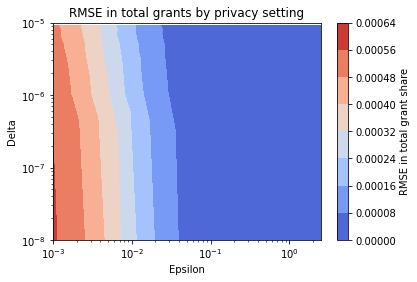

In [91]:
from matplotlib.ticker import FormatStrFormatter

grant_type = 'total'

results = calc_total(results)
eps = list(results.index.get_level_values("epsilon").unique())

delts = list(results.index.get_level_values("delta").unique())
mse = np.zeros((len(eps), len(delts)))
for params, alloc in results.groupby(["epsilon", "delta"]):
    
    e, d = params
    error = alloc[f"true_grant_{grant_type}"]/sum(alloc[f"true_grant_{grant_type}"]) \
        - alloc[f"est_grant_{grant_type}"]/sum(alloc[f"est_grant_{grant_type}"])
    mse[eps.index(e), delts.index(d)] = np.sqrt(sum(error**2)/alloc.shape[0])
    
plt.contourf(eps, delts, mse.transpose(), cmap="coolwarm")
ax = plt.gca()
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_yticks([1e-8, 1e-7, 1e-6, 1e-5])
# ax.yaxis.set_major_formatter(FormatStrFormatter("%.2f"))
plt.xlim(None, 2.5)
plt.xlabel("Epsilon")
plt.ylabel("Delta")
plt.title("RMSE in total grants by privacy setting")
plt.colorbar(label="RMSE in total grant share")
plt.show()

# Ground Truth Comparison
How close are our allocation estimates to the actual allocations from 2019? Note that we only have 2020's allocations, when really we need 2021's allocations, which will use the 2019 ACS data (see [here](https://www.nd.gov/dpi/sites/www/files/documents/Educational%20Equity%20%26%20Support/Title%20I/USED%20Census%202019%20Memo.pdf)). But historically the numbers are close.

In [53]:
from dp_policy.titlei.utils import get_allocation_data

true_allocations = get_allocation_data("../data/titlei-allocations_20")
print(true_allocations.columns)
true_allocations["HistAlloc"].sum()

Index(['LEAID', 'District', 'HistAlloc', 'state'], dtype='object')


15999020221.602928

In [55]:
from dp_policy.api import titlei_funding as funding
from dp_policy.titlei.allocators import SonnenbergAuthorizer

allocations = funding(
    SonnenbergAuthorizer, saipe, GroundTruth(saipe), get_sppe("../data/sppe18.xlsx")
)
allocs = allocations[
    ["true_grant_total", "true_grant_basic", "true_grant_concentration", "true_grant_targeted", "true_children_total", "true_children_eligible"]
].join(true_allocations[["HistAlloc", "District"]])
allocs["error"] = allocs.HistAlloc - allocs.true_grant_total
allocs.true_grant_total.sum()

[WARN] Dropping districts with missing SPPE data: ['Puerto Rico']
136021116192.56747 authorized reduced to 15999020221.602928 allocated.
136021116192.56747 authorized reduced to 15999020221.602928 allocated.


15999046700.71252

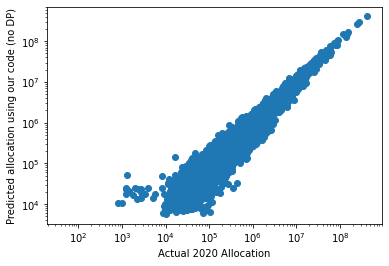

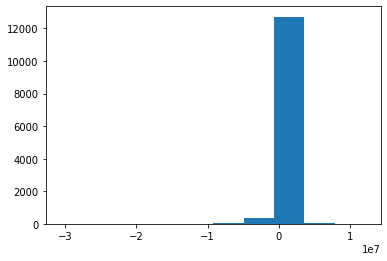

In [57]:
ax = plt.gca()
ax.set_yscale('log')
ax.set_xscale('log')
plt.scatter(allocs.HistAlloc, allocs.true_grant_total)
plt.xlabel("Actual 2020 Allocation")
plt.ylabel("Predicted allocation using our code (no DP)")
plt.show()
plt.hist(allocs.error)
plt.show()

Our method seems to be a little heteroskedastic. Variation could be due to 1) approximations in our funding algo; 2) differences in data.

In [58]:
# error per student
allocs["error_per_capita"] = allocs.error / allocs.true_children_total
np.mean(allocs.error_per_capita), np.sqrt(np.mean(allocs.error_per_capita**2))

(20.879231455964167, 148.36257841383988)

In [59]:
allocs.sort_values("error_per_capita").head(10)

true_grant_total  true_grant_basic  \
State FIPS Code District ID                                       
30              9210             5.259479e+04      46843.071951   
35              330              2.510612e+05     182321.355553   
41              3630             8.201031e+04      68626.885861   
35              1                1.175623e+05      93669.687257   
6               19920            4.708628e+04      38146.911424   
30              13140            2.705267e+04      28105.843171   
6               37470            3.366669e+05     273051.576512   
13              5100             1.278281e+06     996370.877624   
30              19740            2.142242e+04      22484.674536   
48              31950            2.047227e+04      21744.748827   

                             true_grant_concentration  true_grant_targeted  \
State FIPS Code District ID                                                  
30              9210                     6.349072e+04         5.122794e+04   
35              330                      2.471169e+05         2.938792e+05   
41              3630                     9.301633e+04         8.515564e+04   
35              1                        1.269591e+05         1.276975e+05   
6               19920                    5.170402e+04         5.039245e+04   
30              13140                    3.809443e+04         2.155492e+04   
6               37470                    3.700919e+05         3.599461e+05   
13              5100                     1.350473e+06         1.414921e+06   
30              19740                    3.047555e+04         1.679604e+04   
48              31950                    2.947266e+04         1.574353e+04   

                             true_children_total  true_children_eligible  \
State FIPS Code District ID                                                
30              9210                          55                      25   
35              330                          166                     109   
41              3630                          74                      36   
35              1                            109                      56   
6               19920                         31                      19   
30              13140                         39                      15   
6               37470                        295                     136   
13              5100                        1167                     578   
30              19740                         34                      12   
48              31950                         33                      13   

                                 HistAlloc  \
State FIPS Code District ID                  
30              9210           1308.576975   
35              330          119891.947939   
41              3630          24329.785959   
35              1             37999.407212   
6               19920         25151.928704   
30              13140             0.000000   
6               37470        142635.600476   
13              5100         533694.657463   
30              19740             0.000000   
48              31950             0.000000   

                                                                   District  \
State FIPS Code District ID                                                   
30              9210                          Drummond High School District   
35              330                             Carrizozo Municipal Schools   
41              3630            Harney County Union High School District 1J   
35              1                                  Vaughn Municipal Schools   
6               19920        Klamath River Union Elementary School District   
30              13140                  Greycliff Elementary School District   
6               37470                      South Fork Union School District   
13              5100                        Treutlen County School District   
30              19740          

# Uncertainty

## Calculating confidence intervals

The simplest approximate measure of uncertainty is given by the Census's median coefficient of varation in the poverty estimates for each district. We can construct a confidence interval for each allocation as follows, ignoring variance due to missing cutoffs (for now) by using the Abowd method.

[WARN] Dropping districts with missing SPPE data: ['Puerto Rico']


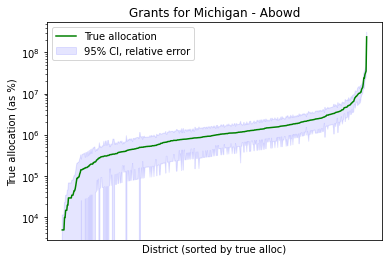

In [116]:
# test with one run of abowd
allocator = AbowdAllocator(
    data(saipe, Laplace(saipe, 2.52, 0), get_sppe("../data/sppe18.xlsx"))
)
allocator.calc_auth()
allocator.calc_uncertainty()
estimates = allocator.estimates[allocator.estimates["State Postal Code"] == "MI"].sort_values("true_grant_total")
y = estimates.true_grant_total
x = estimates.index.get_level_values("District ID").astype('str')
ax = plt.gca()

plt.plot(x, y, color='green', label="True allocation")
ax.fill_between(x, estimates.true_ci_lower, estimates.true_ci_upper, color='b', alpha=0.1, label="95% CI, relative error")
ax.axes.xaxis.set_ticks([])
ax.set_yscale('log')
plt.xlabel("District (sorted by true alloc)")
plt.ylabel("True allocation (as %)")
plt.title(f"Grants for Michigan - Abowd")
ax.legend()
plt.show()

[WARN] Dropping districts with missing SPPE data: ['Puerto Rico']


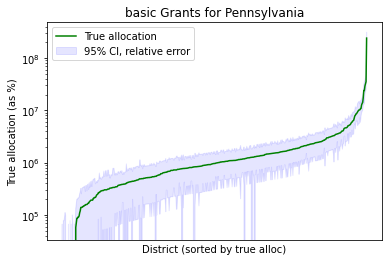

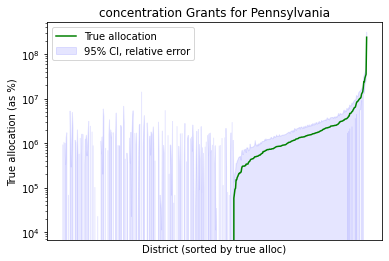

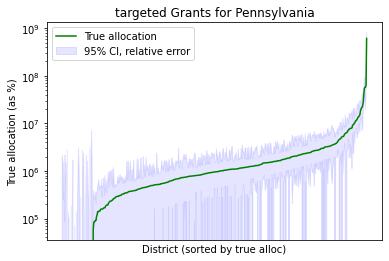

In [118]:
# test with one run of Sonnenberg
allocator = SonnenbergAuthorizer(
    data(saipe, Laplace(saipe, 2.52, 0), get_sppe("../data/sppe18.xlsx"))
)
allocator.calc_auth()
allocator.calc_uncertainty()

for grant_type in ["basic", "concentration", "targeted"]:
    estimates = allocator.estimates[allocator.estimates["State Postal Code"] == "MI"].sort_values(f"true_grant_{grant_type}")
    y = estimates[f"true_grant_{grant_type}"]
    x = estimates.index.get_level_values("District ID").astype('str')
    ax = plt.gca()

    plt.plot(x, y, color='green', label="True allocation")
    ax.fill_between(x, estimates[f"true_grant_{grant_type}_ci_upper"], estimates[f"true_grant_{grant_type}_ci_lower"], color='b', alpha=0.1, label="95% CI, relative error")
    ax.axes.xaxis.set_ticks([])
    ax.set_yscale('log')
    plt.xlabel("District (sorted by true alloc)")
    plt.ylabel("True allocation (as %)")
    plt.title(f"{grant_type} Grants for Pennsylvania")
    ax.legend()
    plt.show()

## Measures of "cheating" - districts receiving less than they should, if data were perfect

One method (see notes) is to compute the expected value of $y$ (the expected allocation) given the following assumptions:
1. $\mu$ is normally distributed
2. $\hat{\mu}$ is unbiased
3. $\hat{\nu}$ is unbiased and a point mass

See notes for the expectation math.

An example for basic grants:

[WARN] Dropping districts with missing SPPE data: ['Puerto Rico']


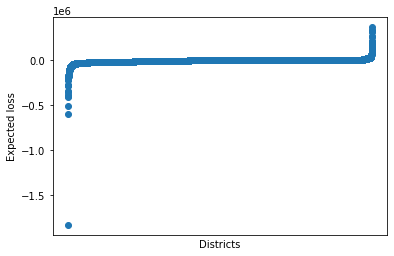

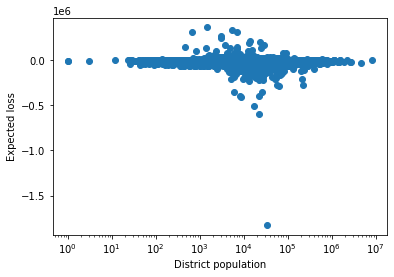

28603.537629958762

In [119]:
allocator = SonnenbergAuthorizer(
    data(saipe, Laplace(saipe, 2.52, 0), get_sppe("../data/sppe18.xlsx"))
)
allocator.calc_auth()
allocator.calc_uncertainty()

df = allocator.estimates

df = df.sort_values("expected_loss_basic")
ax = plt.gca()
ax.axes.xaxis.set_ticks([])
# ax.set_yscale('log')
plt.scatter(range(len(df)), df["expected_loss_basic"])
plt.xlabel("Districts")
plt.ylabel("Expected loss")
plt.show()

ax = plt.gca()
ax.axes.xaxis.set_ticks([])
plt.scatter(allocator.estimates.true_pop_total, df["expected_loss_basic"])
ax.set_xscale('log')
plt.xlabel("District population")
plt.ylabel("Expected loss")
plt.show()

# RMSE
np.sqrt(np.mean((df.expected_loss_basic)**2))

In [120]:
df["expected_loss_per_child_poverty"] = df.expected_loss_basic / df.true_children_poverty
df.sort_values("expected_loss_per_child_poverty", ascending=True).dropna().tail()

State Postal Code  \
State FIPS Code District ID                     
9               30                         CT   
25              8530                       MA   
9               870                        CT   
36              15270                      NY   
34              6600                       NJ   

                                                            Name  \
State FIPS Code District ID                                        
9               30                       Andover School District   
25              8530           New Salem-Wendell School District   
9               870                    Colebrook School District   
36              15270        Indian Lake Central School District   
34              6600             Hampton Borough School District   

                             true_pop_total  true_children_total  \
State FIPS Code District ID                                        
9               30                     3259                  270   
25              8530                   1807                  118   
9               870                    1408                   93   
36              15270                  1234                  114   
34              6600                   1343                  117   

                             true_children_poverty    cv  est_pop_total  \
State FIPS Code District ID                                               
9               30                              10  0.42    3258.522833   
25              8530                            10  0.67    1805.708033   
9               870                             10  0.67    1407.901831   
36              15270                           10  0.67    1234.283971   
34              6600                            10  0.67    1342.578518   

                             est_children_total  est_children_poverty  \
State FIPS Code District ID                                             
9               30                   269.923864             10.869113   
25              8530                 116.266458             10.547026   
9               870                   93.072815              6.711421   
36              15270                113.524310             11.280707   
34              6600                 113.447533             11.729647   

                             true_children_eligible  ...  \
State FIPS Code District ID                          ...   
9               30                               10  ...   
25              8530                             10  ...   
9               870                              10  ...   
36              15270                            10  ...   
34              6600                             10  ...   

                             est_grant_concentration_ci_lower  \
State FIPS Code District ID                                     
9               30                                        0.0   
25              8530                                      0.0   
9               870                                       0.0   
36              15270                                     0.0   
34              6600                                      0.0   

                             est_grant_targeted_ci_upper  \
State FIPS Code District ID                                
9               30                         123919.207234   
25              8530                       171623.438758   
9               870                         97081.612144   
36              15270                      184384.532182   
34              6600                       200619.467952   

                             est_grant_targeted_ci_lower   est_ci_upper  \
State FIPS Code District ID                                               
9               30                                   0.0  247838.414467   
25              8530                                 0.0  476751.741421   
9               870                                  0.0  291244.836433   
36              152

Another method is just to try to compute the probability of eligibility. This might tell us if some districts are getting lucky, unlucky in receiving funding.

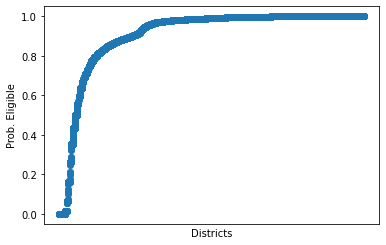

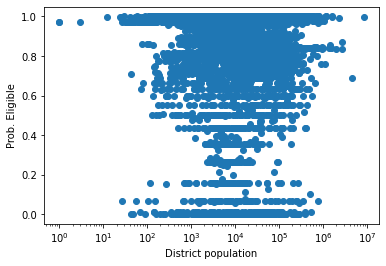

In [121]:
df = df.sort_values("prob_el_basic")
ax = plt.gca()
ax.axes.xaxis.set_ticks([])
# ax.set_yscale('log')
plt.scatter(range(len(df)), df["prob_el_basic"])
plt.xlabel("Districts")
plt.ylabel("Prob. Eligible")
plt.show()

ax = plt.gca()
ax.axes.xaxis.set_ticks([])
plt.scatter(allocator.estimates.true_pop_total, df["prob_el_basic"])
ax.set_xscale('log')
plt.xlabel("District population")
plt.ylabel("Prob. Eligible")
plt.show()

In [122]:
# difference in prob of eligibility vs actual eligibility
# df["eligible_basic"] = df.true_grant_basic > 0.0
eps = 18

allocator = SonnenbergAuthorizer(
    data(saipe, Laplace(saipe, eps, 0.5), get_sppe("../data/sppe18.xlsx"))
)
allocator.calc_auth()
allocator.calc_uncertainty()

df = allocator.estimates

# calc prop. of districts with prob > k who were ineligible
ks = np.linspace(0, 1)
k_eligible_true = [((df.prob_el_basic > k) & ~df.true_eligible_basic).sum() for k in ks]

trials = []
hist = []
n = 100
for trial in tqdm(range(n)):
    allocatort = SonnenbergAuthorizer(
        data(saipe, Laplace(saipe, eps, 0), get_sppe("../data/sppe18.xlsx"))
    )
    allocatort.calc_auth()
    allocatort.calc_uncertainty()
    trial = allocatort.estimates
    trials.append(trial)

[WARN] Dropping districts with missing SPPE data: ['Puerto Rico']


  0%|          | 0/100 [00:00<?, ?it/s]

[WARN] Dropping districts with missing SPPE data: ['Puerto Rico']
[WARN] Dropping districts with missing SPPE data: ['Puerto Rico']
[WARN] Dropping districts with missing SPPE data: ['Puerto Rico']
[WARN] Dropping districts with missing SPPE data: ['Puerto Rico']
[WARN] Dropping districts with missing SPPE data: ['Puerto Rico']
[WARN] Dropping districts with missing SPPE data: ['Puerto Rico']
[WARN] Dropping districts with missing SPPE data: ['Puerto Rico']
[WARN] Dropping districts with missing SPPE data: ['Puerto Rico']
[WARN] Dropping districts with missing SPPE data: ['Puerto Rico']
[WARN] Dropping districts with missing SPPE data: ['Puerto Rico']
[WARN] Dropping districts with missing SPPE data: ['Puerto Rico']
[WARN] Dropping districts with missing SPPE data: ['Puerto Rico']
[WARN] Dropping districts with missing SPPE data: ['Puerto Rico']
[WARN] Dropping districts with missing SPPE data: ['Puerto Rico']
[WARN] Dropping districts with missing SPPE data: ['Puerto Rico']
[WARN] Dro

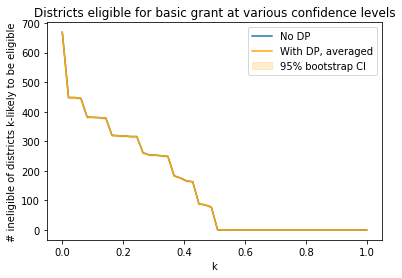

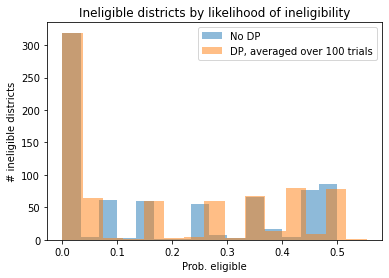

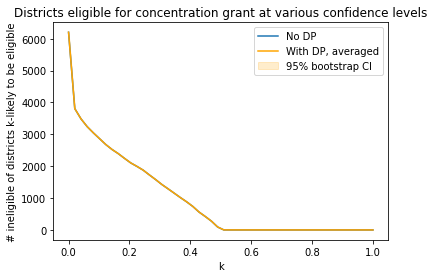

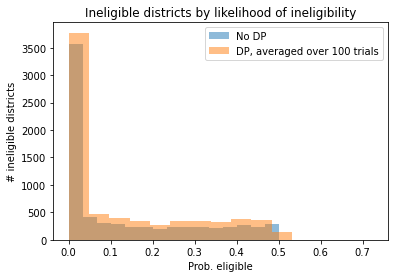

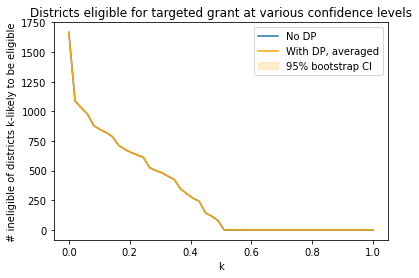

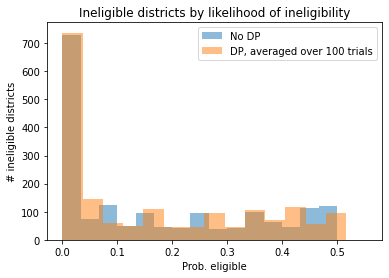

In [21]:
alpha = 0.01

for grant_type in ["basic", "concentration", "targeted"]:
    k_eligible_est = [
        [((trial[f"prob_el_{grant_type}"] > k) & ~trial[f"est_eligible_{grant_type}"]).sum() for k in ks]
        for trial in trials
    ]
    upper = np.percentile(np.array(k_eligible_est), 1-alpha/2, axis=0)
    lower = np.percentile(np.array(k_eligible_est), alpha/2, axis=0)
    mean = np.mean(np.array(k_eligible_est), axis=0)

    k_eligible_true = [((df[f"prob_el_{grant_type}"] > k) & ~df[f"true_eligible_{grant_type}"]).sum() for k in ks]
    
    plt.plot(ks, k_eligible_true, label="No DP")
    plt.plot(ks, mean, color='orange', label="With DP, averaged")
    plt.fill_between(ks, lower, upper, color='orange', alpha=0.2, label="95% bootstrap CI")
    plt.legend()
    plt.ylabel("# ineligible of districts k-likely to be eligible")
    plt.xlabel("k")
    plt.title(f"Districts eligible for {grant_type} grant at various confidence levels")
    plt.show()


    # histogram
    plt.hist(df[f"prob_el_{grant_type}"][~df[f"true_eligible_{grant_type}"]], bins=15, label="No DP", alpha=0.5)
    hist = [k for k in trial[f"prob_el_{grant_type}"][~trial[f"est_eligible_{grant_type}"]] for trial in trials]
    plt.hist(hist, bins=15, weights=1/n*np.ones(len(hist)), label=f"DP, averaged over {n} trials", alpha=0.5)
    plt.title("Ineligible districts by likelihood of ineligibility")
    plt.xlabel("Prob. eligible")
    plt.ylabel("# ineligible districts")
    plt.legend()
    plt.show()

what kinds of districts are in the 1% of "cheated" districts? let's look at k=0.5

## Results

In [151]:
from dp_policy.api import titlei_funding

# 100 trials of DP
trials_laplace = []
trials_gaussian = []
for i in range(100):
    trials_laplace.append(funding(SonnenbergAuthorizer, saipe, Laplace(saipe, 17, 0), get_sppe("../data/sppe18.xlsx")))
    trials_gaussian.append(funding(SonnenbergAuthorizer, saipe, Gaussian(saipe, 17, 0.8), get_sppe("../data/sppe18.xlsx")))

[WARN] Dropping districts with missing SPPE data: ['Puerto Rico']
136021116192.56747 authorized reducedto 15999020221.602928 allocated.
136021636582.98068 authorized reducedto 15999020221.602928 allocated.
[WARN] Dropping districts with missing SPPE data: ['Puerto Rico']
136021116192.56747 authorized reducedto 15999020221.602928 allocated.
136015183589.83414 authorized reducedto 15999020221.602928 allocated.
[WARN] Dropping districts with missing SPPE data: ['Puerto Rico']
136021116192.56747 authorized reducedto 15999020221.602928 allocated.
136018847725.84697 authorized reducedto 15999020221.602928 allocated.
[WARN] Dropping districts with missing SPPE data: ['Puerto Rico']
136021116192.56747 authorized reducedto 15999020221.602928 allocated.
136026553165.37878 authorized reducedto 15999020221.602928 allocated.
[WARN] Dropping districts with missing SPPE data: ['Puerto Rico']
136021116192.56747 authorized reducedto 15999020221.602928 allocated.
136019298134.1442 authorized reducedto 1

In [152]:
import pickle

pickle.dump(trials_gaussian, open('../results/uncertainty_gaussian_sonnenberg.pkl', 'wb'))
pickle.dump(trials_laplace, open('../results/uncertainty_laplace_sonnenberg.pkl', 'wb'))

In [123]:
import pickle

trials_gaussian = pickle.load( open('../results/uncertainty_gaussian_sonnenberg.pkl', 'rb'))
trials_laplace = pickle.load( open('../results/uncertainty_laplace_sonnenberg.pkl', 'rb'))

[462824020.94161385, 462840299.6673689, 462841737.3173904, 462822855.2437982, 462816482.44983107, 462830999.04026777, 462845746.35956573, 462802600.8257093, 462806049.94182587, 462842226.00936466, 462812324.09494454, 462825477.404486, 462818210.5735216, 462824561.7874051, 462840306.5160426, 462817604.17654556, 462819730.95393896, 462818687.6475747, 462830350.0292324, 462827909.09678173, 462805224.07426506, 462871940.04184407, 462822816.4434567, 462810964.1891345, 462823862.1024415, 462804846.64482874, 462810856.5915192, 462838668.29985064, 462842426.3687169, 462893275.97106534, 462852557.9261036, 462846578.9573317, 462825218.91440845, 462770666.3817068, 462822191.5956028, 462825361.3744827, 462890905.44549876, 462828829.3798849, 462844642.1573651, 462831280.6207208, 462809818.0116389, 462876629.0044988, 462834396.03578705, 462815231.08159953, 462829029.02726537, 462820261.23617554, 462831572.09701484, 462802679.17332053, 462818791.49010426, 462839147.35206664, 462839853.49715096, 46279

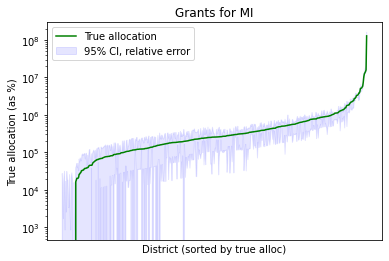

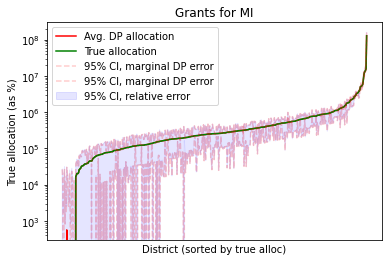

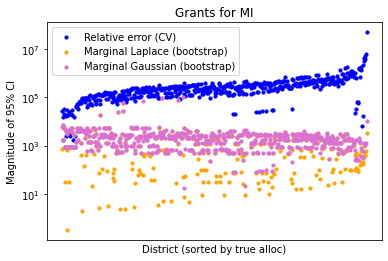

In [132]:
import scipy.stats as stats

def plot_uncertainty(grants, grants_other=None, state="MI", alpha=0.05):
    z = stats.norm.ppf(1-alpha/2)
    
    grants = [
        sample[sample["State Postal Code"] == state].sort_values("true_grant_total")
        for sample in grants
    ]
    baseline = grants[0]
    x = baseline.index.get_level_values("District ID").astype('str')
    y = baseline.true_grant_total
    
    print(list(grant.est_grant_total.sum() for grant in grants))
    
    # percentile interval from DP (bootstrapping) - 95% of samples differed by at most this much
    samples_mean = [
        sample.est_grant_total
        for sample in grants
    ]
    samples_upper = [
        sample.est_ci_upper
        for sample in grants
    ]
    samples_lower = [
        sample.est_ci_lower
        for sample in grants
    ]
    # get value for which 95% of samples are above (for lower) or below (for upper)
    mean = np.mean(samples_mean, axis=0)
    ci_lower = np.percentile(samples_lower, alpha/2, axis=0)
    ci_upper = np.percentile(samples_upper, 1-alpha/2, axis=0)
    
    # CI from relative error - 95% of samples differ by at most this much
    ax = plt.gca()
    ax.fill_between(x, baseline.true_ci_lower, baseline.true_ci_upper, color='b', alpha=0.1, label="95% CI, relative error")
    plt.plot(x, y, color='green', label="True allocation")
    ax.axes.xaxis.set_ticks([])
    ax.set_yscale('log')
    plt.xlabel("District (sorted by true alloc)")
    plt.ylabel("True allocation (as %)")
    plt.title(f"Grants for {state}")
    ax.legend()
    plt.show()

    ax = plt.gca()
    ax.fill_between(x, baseline.true_ci_lower, baseline.true_ci_upper, color='b', alpha=0.1, label="95% CI, relative error")
    plt.plot(x, mean, color='r', label="Avg. DP allocation")
    plt.plot(x, y, color='green', label="True allocation")
    plt.plot(x, ci_lower, 'r--', alpha=0.2, label="95% CI, marginal DP error")
#     ax.fill_between(x, baseline.true_ci_lower, ci_lower, color='r', alpha=0.1, label="95% CI, marginal DP error")
    plt.plot(x, ci_upper, 'r--', alpha=0.2, label="95% CI, marginal DP error")
#     ax.fill_between(x, baseline.true_ci_upper, ci_upper, color='r', alpha=0.1, label="95% CI, marginal DP error")
    ax.axes.xaxis.set_ticks([])
    ax.set_yscale('log')
    plt.xlabel("District (sorted by true alloc)")
    plt.ylabel("True allocation (as %)")
    plt.title(f"Grants for {state}")
    ax.legend()
    plt.show()
    
    # plot of interval magnitude
    ax = plt.gca()
    ci = np.abs(baseline.true_ci_upper - baseline.true_ci_lower)
    plt.scatter(x, ci, s=10, color='b', label="Relative error (CV)")
    
    samples = [
        np.abs(sample.est_ci_upper - sample.est_ci_lower)
        for sample in grants
    ]
    plt.scatter(x, ci - np.percentile(samples, 1-alpha/2, axis=0), s=10, color='orange', label="Marginal Laplace (bootstrap)")
    
    if grants_other is not None:
        grants_other = [
            sample[sample["State Postal Code"] == state].sort_values("true_grant_total")
            for sample in grants_other
        ]
        samples_other = [
            np.abs(sample.est_ci_upper - sample.est_ci_lower)
            for sample in grants_other
        ]
        plt.scatter(
            x, 
            ci - np.percentile(samples_other, 1-alpha/2, axis=0),
            s=10, color='orchid', label="Marginal Gaussian (bootstrap)"
        )


    ax.axes.xaxis.set_ticks([])
    ax.set_yscale('log')
    plt.xlabel("District (sorted by true alloc)")
    plt.ylabel("Magnitude of 95% CI")
    plt.title(f"Grants for {state}")
    ax.legend()
    plt.show()

plot_uncertainty(trials_laplace, trials_gaussian)

# Discrimination

## Data
Using 2014-2018 ACS race data by school district from the NCES. See notes for more details.

Data for just the total child population

In [2]:
from dp_policy.titlei.utils import get_acs_data

demographics = get_acs_data(
    "../data/discrimination/CDP05.txt",
    "demo"
)
print(demographics.shape)
social = get_acs_data(
    "../data/discrimination/CDP02.txt",
    "social"
)
print(social.shape)
economic = get_acs_data(
    "../data/discrimination/CDP03.txt",
    "social"
)
print(economic.shape)
housing = get_acs_data(
    "../data/discrimination/CDP04.txt",
    "housing"
)
print(housing.shape)

(11721, 256)
(11720, 340)


/opt/miniconda3/envs/dp-acs/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3357: DtypeWarning: Columns (183,184,185,186) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


(11721, 202)


/opt/miniconda3/envs/dp-acs/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3357: DtypeWarning: Columns (161,162,279,280,283,284,287,288,291,292,295,296,299,300,303,304,307,308,315,316,319,320) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


(11721, 494)


In [3]:
acs = demographics.join(social, lsuffix="_demo", rsuffix="_social", how="inner")\
    .join(economic, rsuffix="_econ", how="inner")\
    .join(housing, rsuffix="_housing", how="inner")
print(acs.shape)
print(acs[acs['Total population (RACE) - est'].isna()].shape)
# print(list(c for c in acs.columns if "est" in c or "pct" in c))

(11720, 1292)
(0, 1292)


In [4]:
saipe = get_saipe("../data/saipe19.xls")
# saipe = saipe.join(acs, how="inner")

In [95]:
from dp_policy.titlei.mechanisms import Gaussian

# run 100 trials for a signle eps, delta combo
results = test_params(
    saipe,
    Gaussian, 
    eps=[0.01],
    delta=[1e-6],
    trials=100
)
pickle.dump(results, open('../results/discrimination.pkl', 'wb'))

100 iters:


trial:   0%|          | 0/100 [00:00<?, ?it/s]

delta:   0%|          | 0/1 [00:00<?, ?it/s]

eps:   0%|          | 0/1 [00:00<?, ?it/s]

delta:   0%|          | 0/1 [00:00<?, ?it/s]

eps:   0%|          | 0/1 [00:00<?, ?it/s]

delta:   0%|          | 0/1 [00:00<?, ?it/s]

eps:   0%|          | 0/1 [00:00<?, ?it/s]

delta:   0%|          | 0/1 [00:00<?, ?it/s]

eps:   0%|          | 0/1 [00:00<?, ?it/s]

delta:   0%|          | 0/1 [00:00<?, ?it/s]

eps:   0%|          | 0/1 [00:00<?, ?it/s]

delta:   0%|          | 0/1 [00:00<?, ?it/s]

eps:   0%|          | 0/1 [00:00<?, ?it/s]

delta:   0%|          | 0/1 [00:00<?, ?it/s]

eps:   0%|          | 0/1 [00:00<?, ?it/s]

delta:   0%|          | 0/1 [00:00<?, ?it/s]

eps:   0%|          | 0/1 [00:00<?, ?it/s]

delta:   0%|          | 0/1 [00:00<?, ?it/s]

eps:   0%|          | 0/1 [00:00<?, ?it/s]

delta:   0%|          | 0/1 [00:00<?, ?it/s]

eps:   0%|          | 0/1 [00:00<?, ?it/s]

delta:   0%|          | 0/1 [00:00<?, ?it/s]

eps:   0%|          | 0/1 [00:00<?, ?it/s]

delta:   0%|          | 0/1 [00:00<?, ?it/s]

eps:   0%|          | 0/1 [00:00<?, ?it/s]

delta:   0%|          | 0/1 [00:00<?, ?it/s]

eps:   0%|          | 0/1 [00:00<?, ?it/s]

delta:   0%|          | 0/1 [00:00<?, ?it/s]

eps:   0%|          | 0/1 [00:00<?, ?it/s]

delta:   0%|          | 0/1 [00:00<?, ?it/s]

eps:   0%|          | 0/1 [00:00<?, ?it/s]

delta:   0%|          | 0/1 [00:00<?, ?it/s]

eps:   0%|          | 0/1 [00:00<?, ?it/s]

delta:   0%|          | 0/1 [00:00<?, ?it/s]

eps:   0%|          | 0/1 [00:00<?, ?it/s]

delta:   0%|          | 0/1 [00:00<?, ?it/s]

eps:   0%|          | 0/1 [00:00<?, ?it/s]

delta:   0%|          | 0/1 [00:00<?, ?it/s]

eps:   0%|          | 0/1 [00:00<?, ?it/s]

delta:   0%|          | 0/1 [00:00<?, ?it/s]

eps:   0%|          | 0/1 [00:00<?, ?it/s]

delta:   0%|          | 0/1 [00:00<?, ?it/s]

eps:   0%|          | 0/1 [00:00<?, ?it/s]

delta:   0%|          | 0/1 [00:00<?, ?it/s]

eps:   0%|          | 0/1 [00:00<?, ?it/s]

delta:   0%|          | 0/1 [00:00<?, ?it/s]

eps:   0%|          | 0/1 [00:00<?, ?it/s]

delta:   0%|          | 0/1 [00:00<?, ?it/s]

eps:   0%|          | 0/1 [00:00<?, ?it/s]

delta:   0%|          | 0/1 [00:00<?, ?it/s]

eps:   0%|          | 0/1 [00:00<?, ?it/s]

delta:   0%|          | 0/1 [00:00<?, ?it/s]

eps:   0%|          | 0/1 [00:00<?, ?it/s]

delta:   0%|          | 0/1 [00:00<?, ?it/s]

eps:   0%|          | 0/1 [00:00<?, ?it/s]

delta:   0%|          | 0/1 [00:00<?, ?it/s]

eps:   0%|          | 0/1 [00:00<?, ?it/s]

delta:   0%|          | 0/1 [00:00<?, ?it/s]

eps:   0%|          | 0/1 [00:00<?, ?it/s]

delta:   0%|          | 0/1 [00:00<?, ?it/s]

eps:   0%|          | 0/1 [00:00<?, ?it/s]

delta:   0%|          | 0/1 [00:00<?, ?it/s]

eps:   0%|          | 0/1 [00:00<?, ?it/s]

delta:   0%|          | 0/1 [00:00<?, ?it/s]

eps:   0%|          | 0/1 [00:00<?, ?it/s]

delta:   0%|          | 0/1 [00:00<?, ?it/s]

eps:   0%|          | 0/1 [00:00<?, ?it/s]

delta:   0%|          | 0/1 [00:00<?, ?it/s]

eps:   0%|          | 0/1 [00:00<?, ?it/s]

delta:   0%|          | 0/1 [00:00<?, ?it/s]

eps:   0%|          | 0/1 [00:00<?, ?it/s]

delta:   0%|          | 0/1 [00:00<?, ?it/s]

eps:   0%|          | 0/1 [00:00<?, ?it/s]

delta:   0%|          | 0/1 [00:00<?, ?it/s]

eps:   0%|          | 0/1 [00:00<?, ?it/s]

delta:   0%|          | 0/1 [00:00<?, ?it/s]

eps:   0%|          | 0/1 [00:00<?, ?it/s]

delta:   0%|          | 0/1 [00:00<?, ?it/s]

eps:   0%|          | 0/1 [00:00<?, ?it/s]

delta:   0%|          | 0/1 [00:00<?, ?it/s]

eps:   0%|          | 0/1 [00:00<?, ?it/s]

delta:   0%|          | 0/1 [00:00<?, ?it/s]

eps:   0%|          | 0/1 [00:00<?, ?it/s]

delta:   0%|          | 0/1 [00:00<?, ?it/s]

eps:   0%|          | 0/1 [00:00<?, ?it/s]

delta:   0%|          | 0/1 [00:00<?, ?it/s]

eps:   0%|          | 0/1 [00:00<?, ?it/s]

delta:   0%|          | 0/1 [00:00<?, ?it/s]

eps:   0%|          | 0/1 [00:00<?, ?it/s]

delta:   0%|          | 0/1 [00:00<?, ?it/s]

eps:   0%|          | 0/1 [00:00<?, ?it/s]

delta:   0%|          | 0/1 [00:00<?, ?it/s]

eps:   0%|          | 0/1 [00:00<?, ?it/s]

delta:   0%|          | 0/1 [00:00<?, ?it/s]

eps:   0%|          | 0/1 [00:00<?, ?it/s]

delta:   0%|          | 0/1 [00:00<?, ?it/s]

eps:   0%|          | 0/1 [00:00<?, ?it/s]

delta:   0%|          | 0/1 [00:00<?, ?it/s]

eps:   0%|          | 0/1 [00:00<?, ?it/s]

delta:   0%|          | 0/1 [00:00<?, ?it/s]

eps:   0%|          | 0/1 [00:00<?, ?it/s]

delta:   0%|          | 0/1 [00:00<?, ?it/s]

eps:   0%|          | 0/1 [00:00<?, ?it/s]

delta:   0%|          | 0/1 [00:00<?, ?it/s]

eps:   0%|          | 0/1 [00:00<?, ?it/s]

delta:   0%|          | 0/1 [00:00<?, ?it/s]

eps:   0%|          | 0/1 [00:00<?, ?it/s]

delta:   0%|          | 0/1 [00:00<?, ?it/s]

eps:   0%|          | 0/1 [00:00<?, ?it/s]

delta:   0%|          | 0/1 [00:00<?, ?it/s]

eps:   0%|          | 0/1 [00:00<?, ?it/s]

delta:   0%|          | 0/1 [00:00<?, ?it/s]

eps:   0%|          | 0/1 [00:00<?, ?it/s]

delta:   0%|          | 0/1 [00:00<?, ?it/s]

eps:   0%|          | 0/1 [00:00<?, ?it/s]

delta:   0%|          | 0/1 [00:00<?, ?it/s]

eps:   0%|          | 0/1 [00:00<?, ?it/s]

delta:   0%|          | 0/1 [00:00<?, ?it/s]

eps:   0%|          | 0/1 [00:00<?, ?it/s]

delta:   0%|          | 0/1 [00:00<?, ?it/s]

eps:   0%|          | 0/1 [00:00<?, ?it/s]

delta:   0%|          | 0/1 [00:00<?, ?it/s]

eps:   0%|          | 0/1 [00:00<?, ?it/s]

delta:   0%|          | 0/1 [00:00<?, ?it/s]

eps:   0%|          | 0/1 [00:00<?, ?it/s]

delta:   0%|          | 0/1 [00:00<?, ?it/s]

eps:   0%|          | 0/1 [00:00<?, ?it/s]

delta:   0%|          | 0/1 [00:00<?, ?it/s]

eps:   0%|          | 0/1 [00:00<?, ?it/s]

delta:   0%|          | 0/1 [00:00<?, ?it/s]

eps:   0%|          | 0/1 [00:00<?, ?it/s]

delta:   0%|          | 0/1 [00:00<?, ?it/s]

eps:   0%|          | 0/1 [00:00<?, ?it/s]

delta:   0%|          | 0/1 [00:00<?, ?it/s]

eps:   0%|          | 0/1 [00:00<?, ?it/s]

delta:   0%|          | 0/1 [00:00<?, ?it/s]

eps:   0%|          | 0/1 [00:00<?, ?it/s]

delta:   0%|          | 0/1 [00:00<?, ?it/s]

eps:   0%|          | 0/1 [00:00<?, ?it/s]

delta:   0%|          | 0/1 [00:00<?, ?it/s]

eps:   0%|          | 0/1 [00:00<?, ?it/s]

delta:   0%|          | 0/1 [00:00<?, ?it/s]

eps:   0%|          | 0/1 [00:00<?, ?it/s]

delta:   0%|          | 0/1 [00:00<?, ?it/s]

eps:   0%|          | 0/1 [00:00<?, ?it/s]

delta:   0%|          | 0/1 [00:00<?, ?it/s]

eps:   0%|          | 0/1 [00:00<?, ?it/s]

delta:   0%|          | 0/1 [00:00<?, ?it/s]

eps:   0%|          | 0/1 [00:00<?, ?it/s]

delta:   0%|          | 0/1 [00:00<?, ?it/s]

eps:   0%|          | 0/1 [00:00<?, ?it/s]

delta:   0%|          | 0/1 [00:00<?, ?it/s]

eps:   0%|          | 0/1 [00:00<?, ?it/s]

delta:   0%|          | 0/1 [00:00<?, ?it/s]

eps:   0%|          | 0/1 [00:00<?, ?it/s]

delta:   0%|          | 0/1 [00:00<?, ?it/s]

eps:   0%|          | 0/1 [00:00<?, ?it/s]

delta:   0%|          | 0/1 [00:00<?, ?it/s]

eps:   0%|          | 0/1 [00:00<?, ?it/s]

delta:   0%|          | 0/1 [00:00<?, ?it/s]

eps:   0%|          | 0/1 [00:00<?, ?it/s]

delta:   0%|          | 0/1 [00:00<?, ?it/s]

eps:   0%|          | 0/1 [00:00<?, ?it/s]

delta:   0%|          | 0/1 [00:00<?, ?it/s]

eps:   0%|          | 0/1 [00:00<?, ?it/s]

delta:   0%|          | 0/1 [00:00<?, ?it/s]

eps:   0%|          | 0/1 [00:00<?, ?it/s]

delta:   0%|          | 0/1 [00:00<?, ?it/s]

eps:   0%|          | 0/1 [00:00<?, ?it/s]

delta:   0%|          | 0/1 [00:00<?, ?it/s]

eps:   0%|          | 0/1 [00:00<?, ?it/s]

delta:   0%|          | 0/1 [00:00<?, ?it/s]

eps:   0%|          | 0/1 [00:00<?, ?it/s]

delta:   0%|          | 0/1 [00:00<?, ?it/s]

eps:   0%|          | 0/1 [00:00<?, ?it/s]

delta:   0%|          | 0/1 [00:00<?, ?it/s]

eps:   0%|          | 0/1 [00:00<?, ?it/s]

delta:   0%|          | 0/1 [00:00<?, ?it/s]

eps:   0%|          | 0/1 [00:00<?, ?it/s]

delta:   0%|          | 0/1 [00:00<?, ?it/s]

eps:   0%|          | 0/1 [00:00<?, ?it/s]

delta:   0%|          | 0/1 [00:00<?, ?it/s]

eps:   0%|          | 0/1 [00:00<?, ?it/s]

delta:   0%|          | 0/1 [00:00<?, ?it/s]

eps:   0%|          | 0/1 [00:00<?, ?it/s]

delta:   0%|          | 0/1 [00:00<?, ?it/s]

eps:   0%|          | 0/1 [00:00<?, ?it/s]

delta:   0%|          | 0/1 [00:00<?, ?it/s]

eps:   0%|          | 0/1 [00:00<?, ?it/s]

delta:   0%|          | 0/1 [00:00<?, ?it/s]

eps:   0%|          | 0/1 [00:00<?, ?it/s]

delta:   0%|          | 0/1 [00:00<?, ?it/s]

eps:   0%|          | 0/1 [00:00<?, ?it/s]

delta:   0%|          | 0/1 [00:00<?, ?it/s]

eps:   0%|          | 0/1 [00:00<?, ?it/s]

delta:   0%|          | 0/1 [00:00<?, ?it/s]

eps:   0%|          | 0/1 [00:00<?, ?it/s]

delta:   0%|          | 0/1 [00:00<?, ?it/s]

eps:   0%|          | 0/1 [00:00<?, ?it/s]

delta:   0%|          | 0/1 [00:00<?, ?it/s]

eps:   0%|          | 0/1 [00:00<?, ?it/s]

## Full dataset

In [5]:
# print(list(c for c in acs.columns if "(RACE)" in c))

In [5]:
results = pickle.load(open('../results/discrimination.pkl', 'rb'))
# for regression
results["error"] =  results.est_grant_total - results.true_grant_total
results["error_per_child"] =  results.error / results['true_children_total']
results["error_per_child_eligible"] =  results.error / results['true_children_eligible']

print(results.shape)
variables = [
    'Total population (RACE) - est',
]
# add race variables
variables += [
    r for r in acs.columns 
    if r.endswith("(RACE) - pct") and "and" not in r and "races" not in r and not r.startswith("One race")
] + ["Two or more races (RACE) - pct"]
# add ethnicity variables
hisp = [
    r for r in acs.columns 
    if r.endswith("(HISPANIC OR LATINO AND RACE) - pct")
]
variables += hisp[1:6]
# add income variables
variables += [
    r for r in acs.columns 
    if r.startswith("Median household income (dollars) (")
]
# add rural/urban - need a 3rd data source
# add immigrant status
variables += [
    "Foreign born (PLACE OF BIRTH) - est",
    "Foreign born (PLACE OF BIRTH) - pct",
    "Not a U.S. citizen (U.S. CITIZENSHIP STATUS) - est",
    "Not a U.S. citizen (U.S. CITIZENSHIP STATUS) - pct"
]
# add language isolation
variables += [
    'Language other than English (LANGUAGE SPOKEN AT HOME) - est',
    'Language other than English (LANGUAGE SPOKEN AT HOME) - pct'
]
# add renters vs. homeowners (housing security)
variables += [
    'Renter-occupied (HOUSING TENURE) - est',
    'Renter-occupied (HOUSING TENURE) - pct',
    'Average household size of renter-occupied unit (HOUSING TENURE) - est'
]
print(variables)
grants = results.join(acs[variables], how="inner")
print(grants.shape)
print(grants[grants["Total population (RACE) - est"].isna()].groupby(["State FIPS Code", "District ID"]).groups.keys())
grants.to_csv("../results/discrimination.csv")

(1318200, 29)
['Total population (RACE) - est', 'White (RACE) - pct', 'Black or African American (RACE) - pct', 'Cherokee tribal grouping (RACE) - pct', 'Chippewa tribal grouping (RACE) - pct', 'Navajo tribal grouping (RACE) - pct', 'Sioux tribal grouping (RACE) - pct', 'Asian (RACE) - pct', 'Asian Indian (RACE) - pct', 'Chinese (RACE) - pct', 'Filipino (RACE) - pct', 'Japanese (RACE) - pct', 'Korean (RACE) - pct', 'Vietnamese (RACE) - pct', 'Other Asian (RACE) - pct', 'Native Hawaiian (RACE) - pct', 'Guamanian or Chamorro (RACE) - pct', 'Samoan (RACE) - pct', 'Some other race (RACE) - pct', 'Two or more races (RACE) - pct', 'Mexican (HISPANIC OR LATINO AND RACE) - pct', 'Puerto Rican (HISPANIC OR LATINO AND RACE) - pct', 'Cuban (HISPANIC OR LATINO AND RACE) - pct', 'Other Hispanic or Latino (HISPANIC OR LATINO AND RACE) - pct', 'Not Hispanic or Latino (HISPANIC OR LATINO AND RACE) - pct', 'Median household income (dollars) (INCOME AND BENEFITS (IN 2019 INFLATION-ADJUSTED DOLLARS)) - e

## Geography viz

In [6]:
geo = gpd.read_file("../data/shapefiles/school_districts_19/schooldistrict_sy1819_tl19.shp")
geo.STATEFP = geo.STATEFP.astype(int)
geo["District ID"] = np.where(geo.UNSDLEA.notna(), geo.UNSDLEA, np.where(geo.SCSDLEA.notna(), geo.SCSDLEA, geo.ELSDLEA))
geo["District ID"] = geo["District ID"].astype(int)
geo = geo.rename(columns={
    "STATEFP": "State FIPS Code"
}).set_index(["State FIPS Code", "District ID"])

<AxesSubplot:>

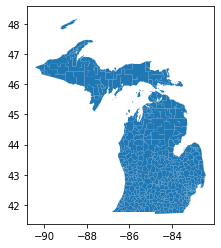

In [7]:
# michigan
geo.loc[26].plot()

In [16]:
# geo.join()
results["percent_eligible"] = results["true_children_eligible"] / results["true_children_total"]
results["switched_eligibility"] = ~((results.est_eligible_targeted == results.true_eligible_targeted) & (results.est_eligible_basic == results.true_eligible_basic) &(results.est_eligible_concentration == results.true_eligible_concentration))
results["became_eligible"] = (results.est_eligible_targeted & ~results.true_eligible_targeted) | (results.est_eligible_basic & ~results.true_eligible_basic) | (results.est_eligible_concentration & ~results.true_eligible_concentration)
results["became_ineligible"] = (~results.est_eligible_targeted & results.true_eligible_targeted) | (~results.est_eligible_basic & results.true_eligible_basic) | (~results.est_eligible_concentration & results.true_eligible_concentration)
joined = geo.join(
    results[[
        "error",
        "error_per_child",
        "error_per_child_eligible",
        "true_children_eligible",
        "true_pop_total",
        "percent_eligible",
        "true_grant_total",
        "switched_eligibility",
        "became_eligible",
        "became_ineligible"
    ]].groupby(["State FIPS Code", "District ID", "epsilon", "delta"]).mean().reset_index(level=["epsilon", "delta"]),
    how="inner"
)
joined.loc[np.isinf(joined["error_per_child"]), "error_per_child"] = np.nan
joined.loc[np.isinf(joined["error_per_child_eligible"]), "error_per_child_eligible"] = np.nan

In [8]:
import matplotlib.colors as pltc

def heatmap(data, label, categorical=False, transform='cube', theme="RdBu", y="error_per_child", vcenter=0):
    fig, ax = plt.subplots(1, figsize=(15, 5), dpi=300)
    
    if transform == 'cube':
        data.loc[:,y] = np.sign(data[y])*np.power(np.abs(data[y]), 1/3)
    if transform == 'log':
        data.loc[:,y] = np.where(data[y] == 0, 0, np.log(data[y]))
    
    # Create colorbar as a legend
    if vcenter is not None and transform != 'log':
        norm = pltc.TwoSlopeNorm(vcenter=0, vmin=data[y].min(), vmax=data[y].max())
    else:
        norm = pltc.Normalize(vmin=data[y].min(), vmax=data[y].max())
    sm = plt.cm.ScalarMappable(cmap=theme, norm=norm)
    data.plot(column=y, cmap=theme, norm=norm, ax=ax, linewidth=0.1, edgecolor='0.2')
    fig.colorbar(sm)
    plt.title(label)
    plt.axis('off')
    plt.show()
    
#     display(data[data[y].notna()].sort_values(y).tail(1))

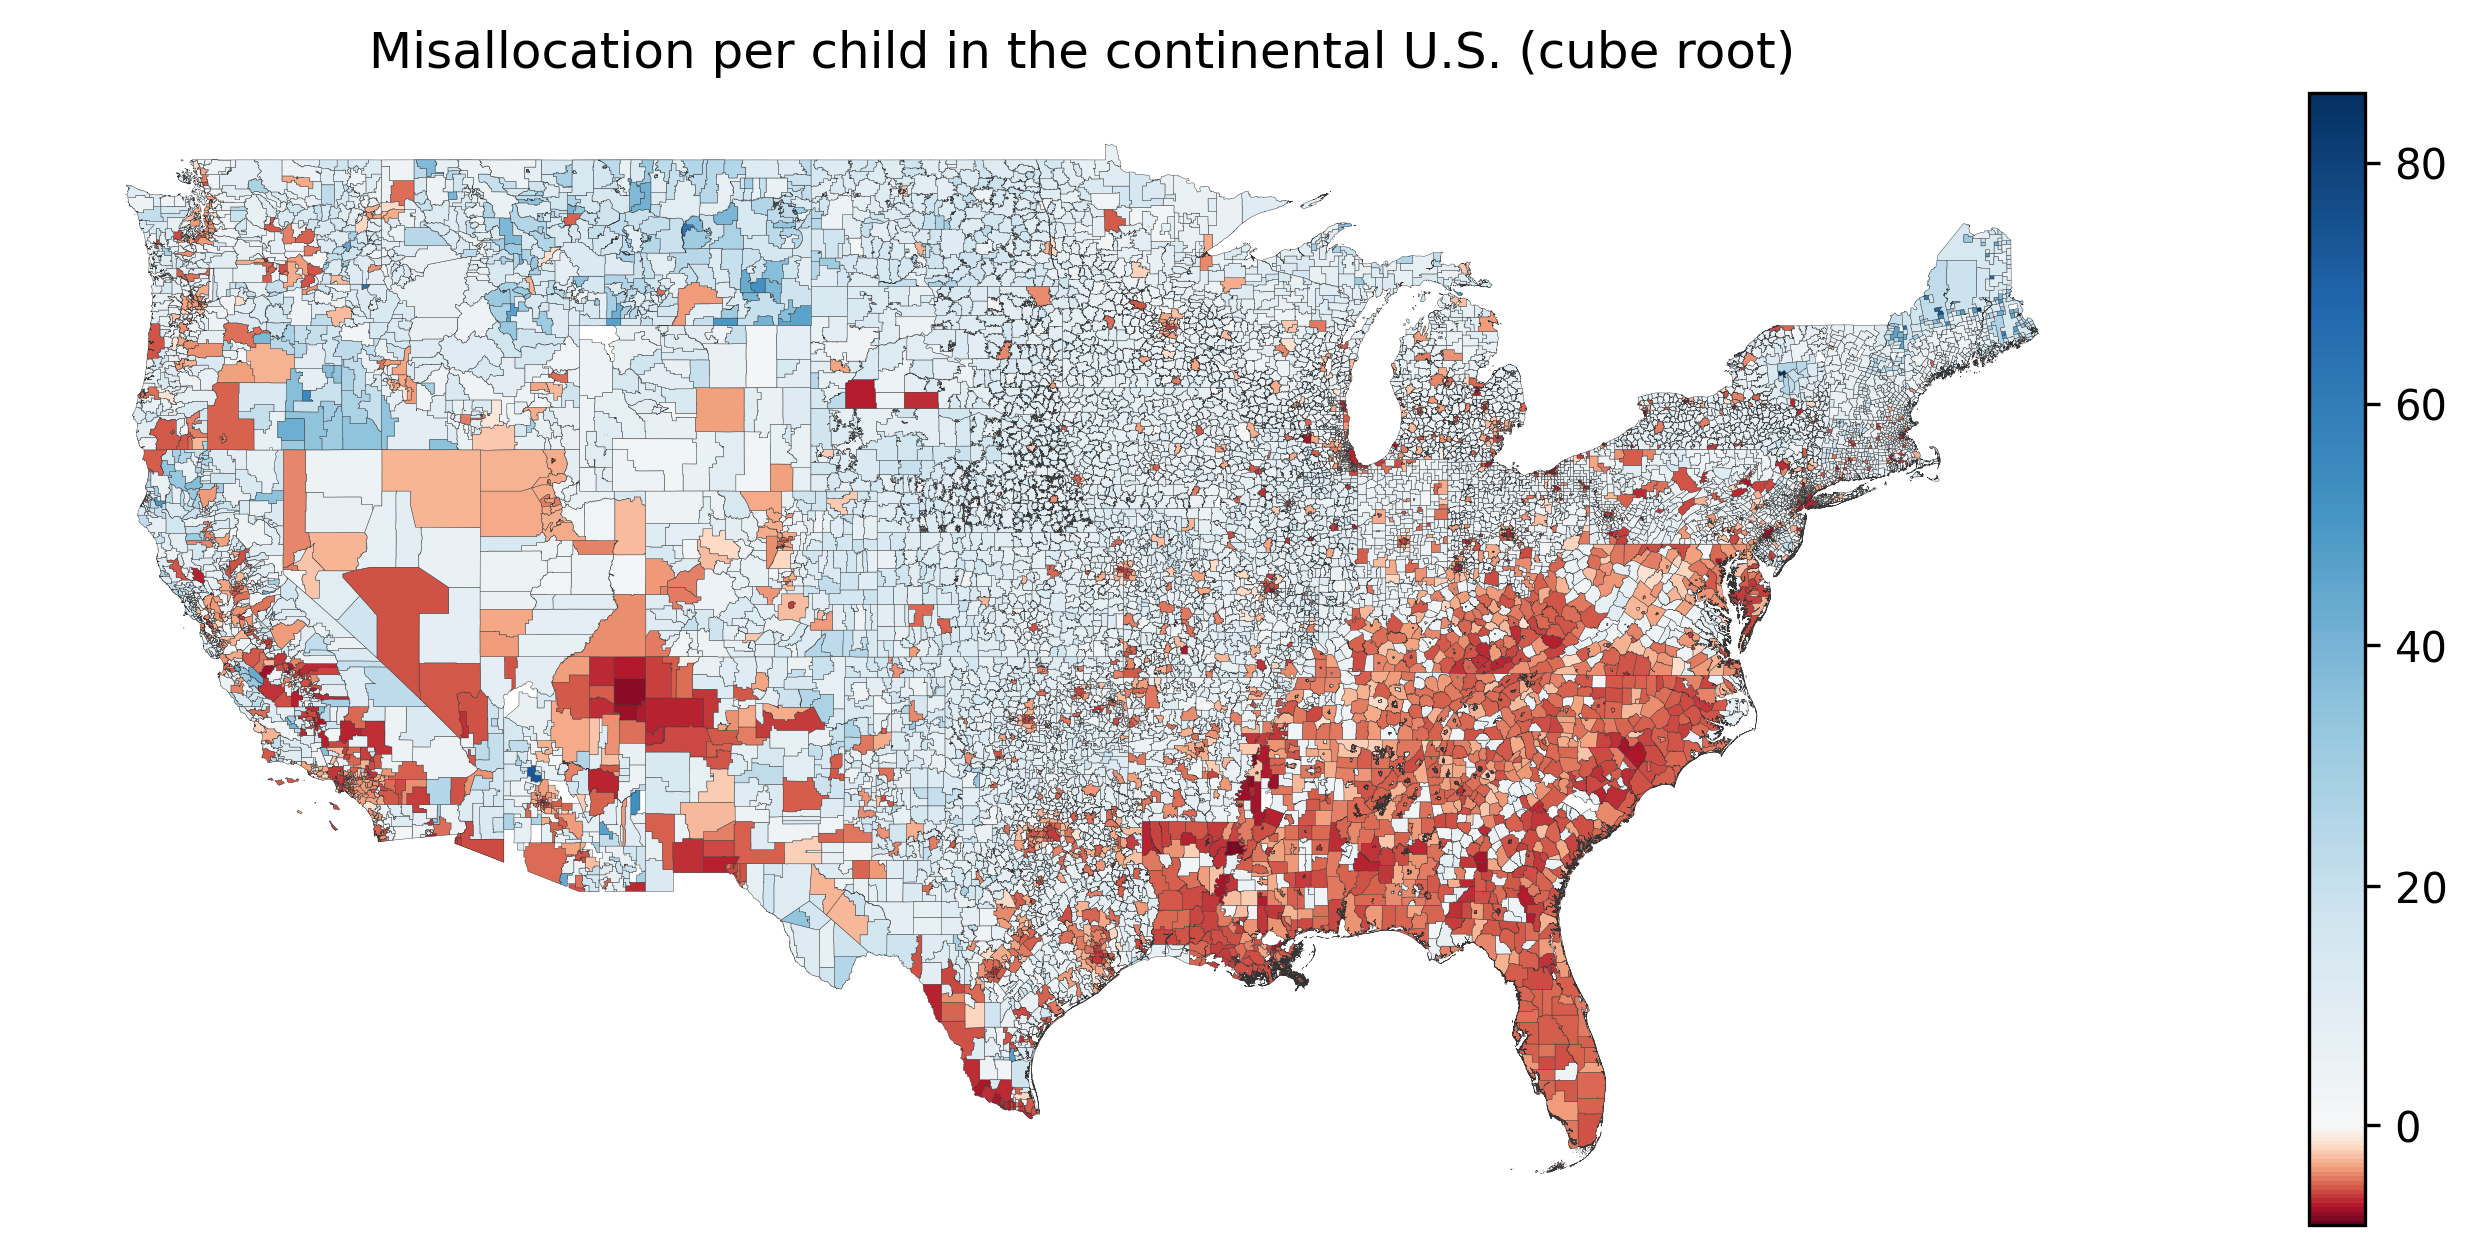

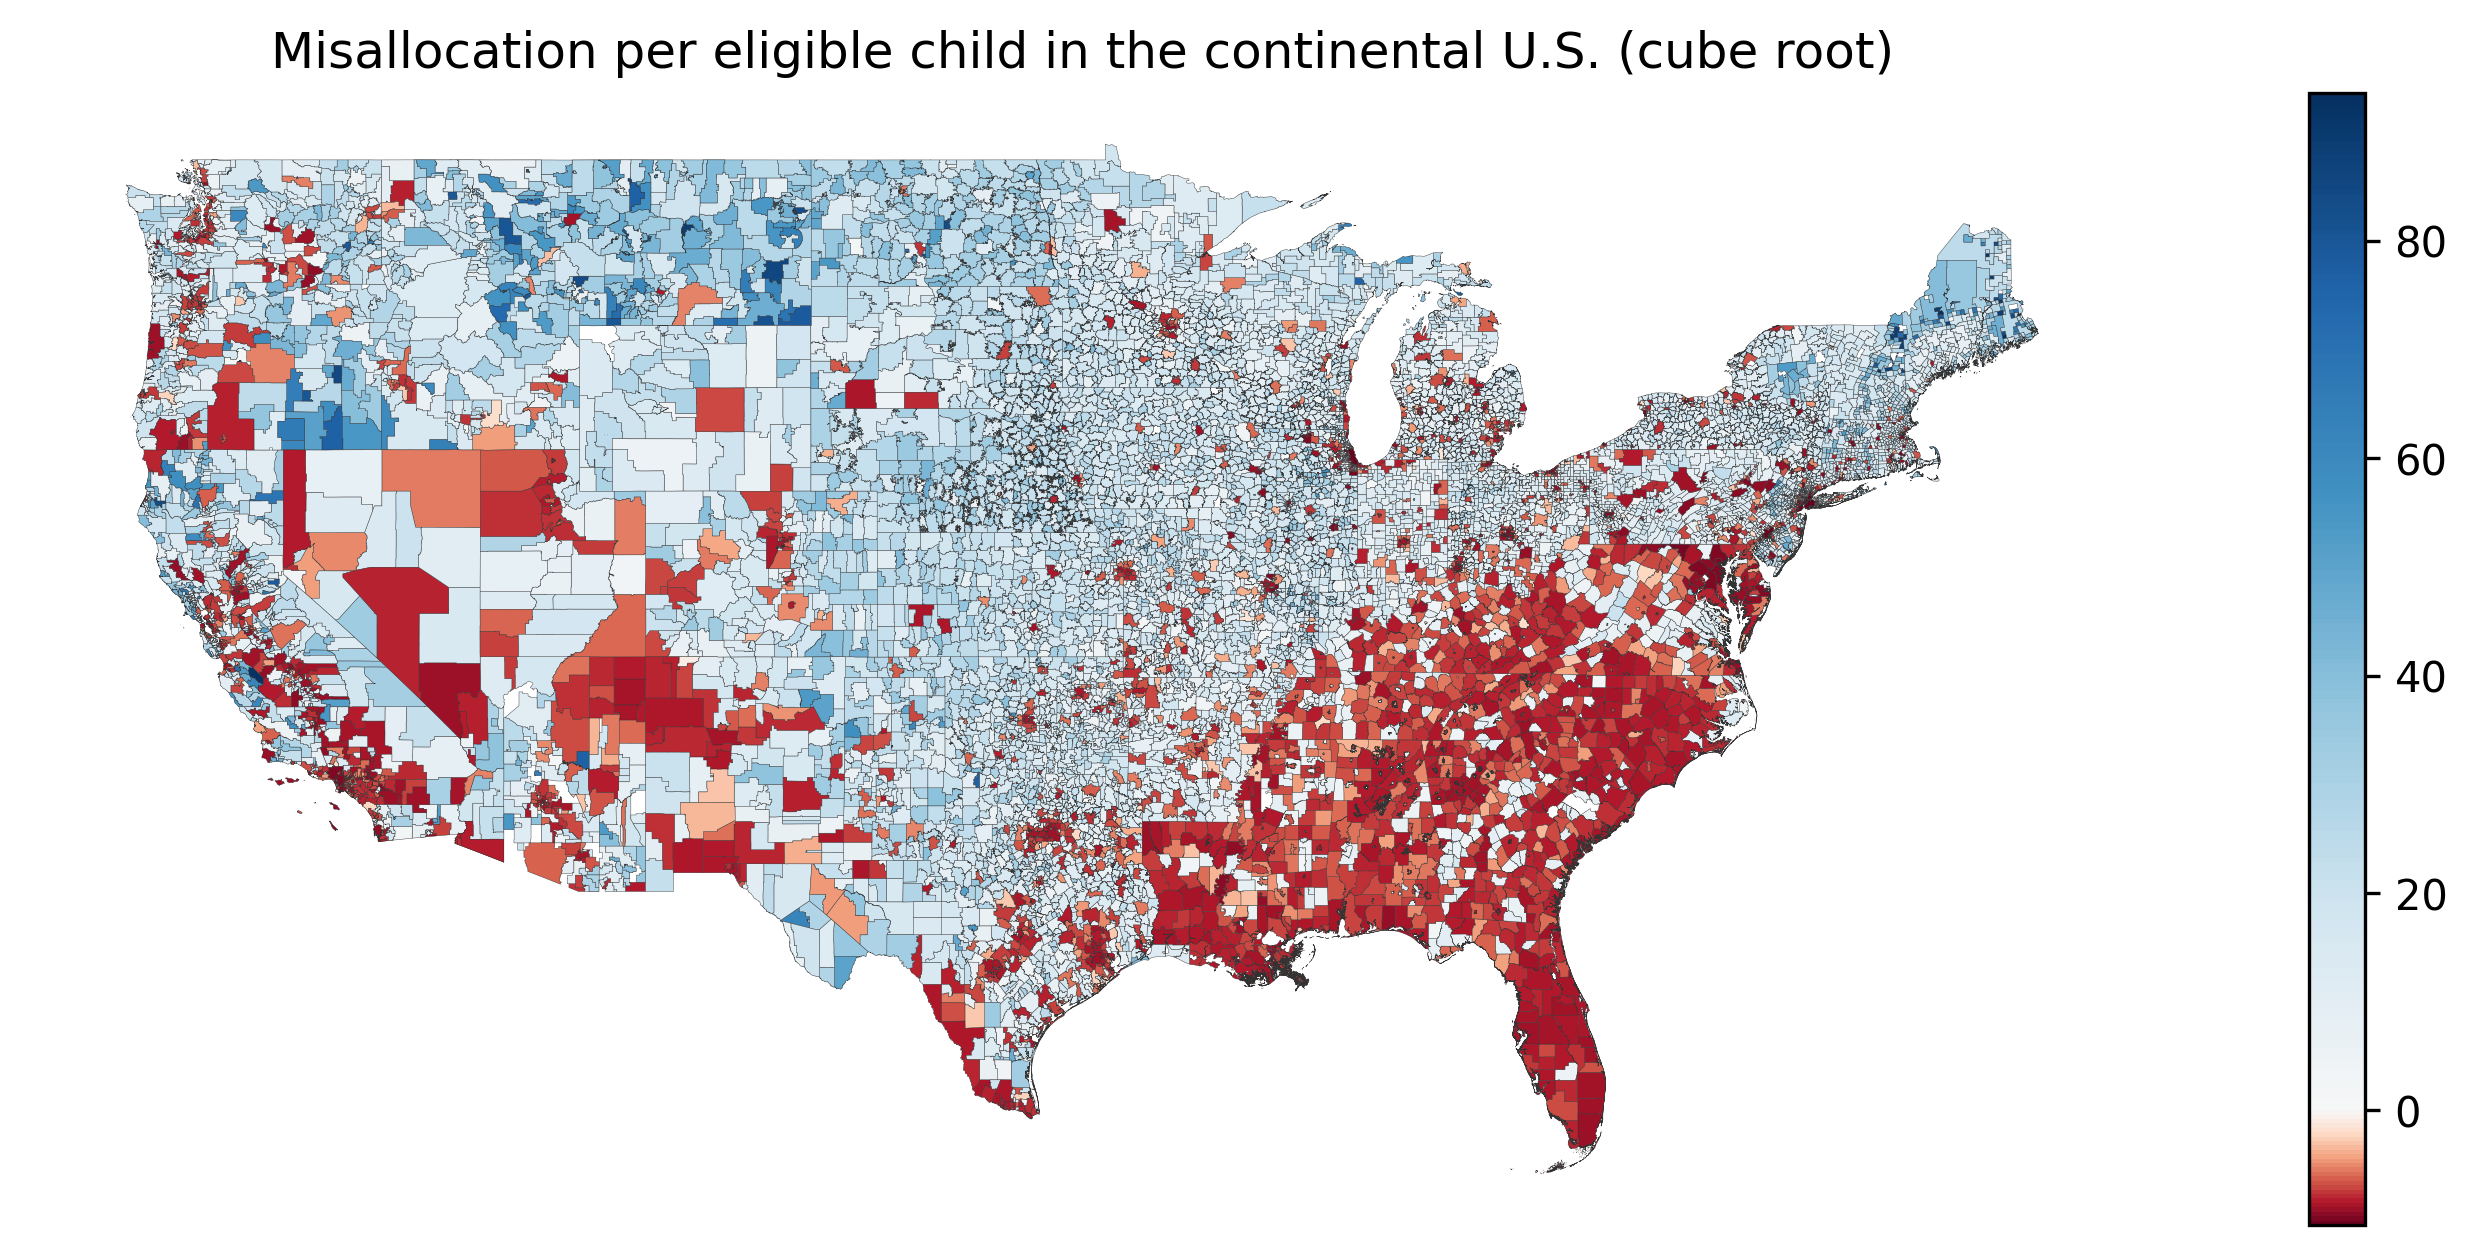

In [58]:
heatmap(
    joined.loc[[
        f for f in joined.index.get_level_values("State FIPS Code").unique()
        if f not in [2, 15]
    ]],
    "Misallocation per child in the continental U.S. (cube root)"
)
heatmap(
    joined.loc[[
        f for f in joined.index.get_level_values("State FIPS Code").unique()
        if f not in [2, 15]
    ]],
    "Misallocation per eligible child in the continental U.S. (cube root)",
    y="error_per_child_eligible"
)

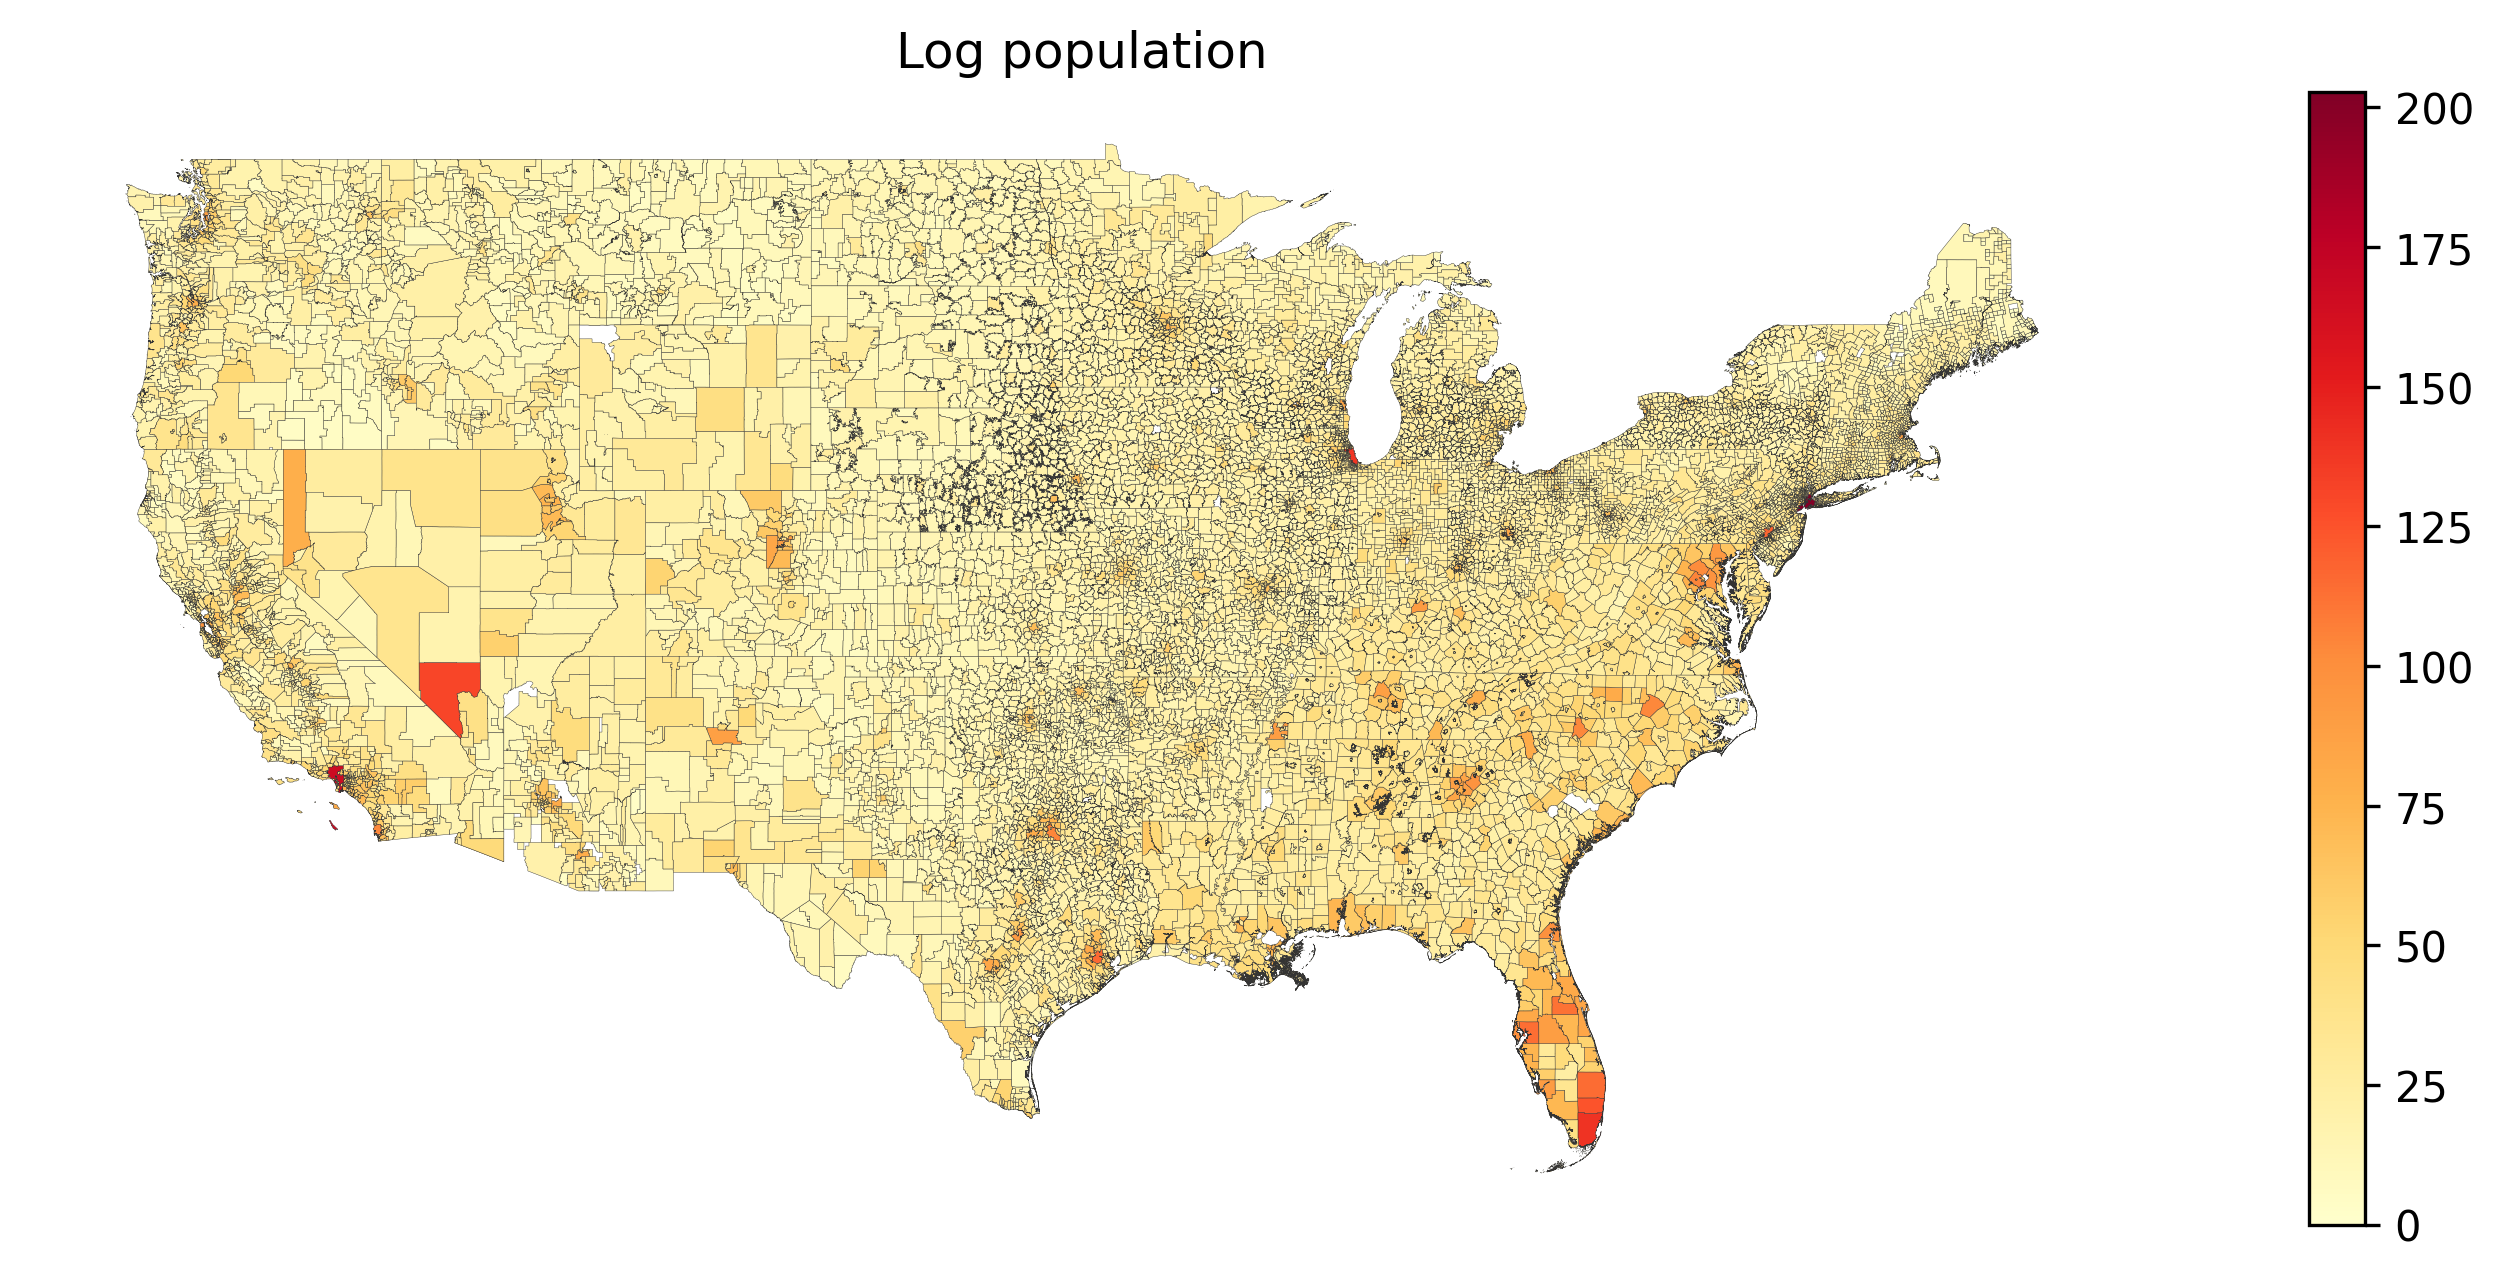

In [15]:
heatmap(
    joined.loc[[
        f for f in joined.index.get_level_values("State FIPS Code").unique()
        if f not in [2, 15]
    ]],
    "Population",
    vcenter=None,
    y="true_pop_total",
    theme="YlOrRd"
)

In [9]:
joined_acs = joined.join(acs['White (RACE) - pct'], how="inner")
joined_acs["prop_nonwhite"] = 1 - acs['White (RACE) - pct'] / 100
joined_acs.prop_nonwhite.describe()
for state in [
#     (26, "Michigan"),
#     (37, "North Carolina"),
    (72, "Puerto Rico"),
    (42, "Pennsylvania")
]:
    heatmap(joined_acs.loc[state[0]], "Prop. non-white-only", y="prop_nonwhite", transform=None, vcenter=None, theme="Blues")
    heatmap(joined.loc[state[0]], "% switched eligibility for any grant", y="switched_eligibility", transform=None, vcenter=None, theme="Oranges")
    heatmap(joined.loc[state[0]], "% became ineligible for any grant", y="became_ineligible", transform=None, vcenter=None, theme="Oranges")
    heatmap(joined.loc[state[0]], "% became eligible for any grant", y="became_eligible", transform=None, vcenter=None, theme="Greens")
    heatmap(joined.loc[state[0]], f"Misallocation per child in {state[1]} (cube root)")
    heatmap(joined.loc[state[0]], f"Misallocation per eligible child in {state[1]} (cube root)", y="error_per_child_eligible")
    heatmap(joined.loc[state[0]], "Log eligible children", y="true_children_eligible", transform='log', vcenter=None, theme="Purples")
    heatmap(joined.loc[state[0]], "% eligible children", y="percent_eligible", transform=None, vcenter=None, theme="Purples")
    heatmap(joined.loc[state[0]], "Log population", y="true_pop_total", transform='log', vcenter=None, theme="Greens")
    heatmap(joined.loc[state[0]], "Log status quo entitlement", y="true_grant_total", transform='log', vcenter=None, theme="Greens")

KeyError: 72

## Random forest

In [24]:
from sklearn.ensemble import RandomForestRegressor

averaged = results.groupby(["State FIPS Code", "District ID"]).mean().join(acs[variables], how="inner")
averaged["misalloc"] = averaged.est_grant_total - averaged.true_grant_total
averaged = averaged.replace('-', np.nan).replace('250,000+', '250000').dropna()
averaged = averaged.fillna(averaged.mean(skipna=True))

In [25]:
from sklearn.tree import plot_tree, DecisionTreeRegressor

dt = DecisionTreeRegressor(max_depth=4)
features = [
    'Total population (RACE) - est',
    'White (RACE) - pct',
    'Black or African American (RACE) - pct',
#     'Cherokee tribal grouping (RACE) - pct',
#     'Chippewa tribal grouping (RACE) - pct',
#     'Navajo tribal grouping (RACE) - pct',
#     'Sioux tribal grouping (RACE) - pct',
    'Asian (RACE) - pct',
#     'Asian Indian (RACE) - pct',
#     'Chinese (RACE) - pct',
#     'Filipino (RACE) - pct',
#     'Japanese (RACE) - pct',
#     'Korean (RACE) - pct',
#     'Vietnamese (RACE) - pct',
#     'Other Asian (RACE) - pct',
#     'Native Hawaiian (RACE) - pct',
#     'Guamanian or Chamorro (RACE) - pct',
#     'Samoan (RACE) - pct',
#     'Some other race (RACE) - pct',
    'Median household income (dollars) (INCOME AND BENEFITS (IN 2019 INFLATION-ADJUSTED DOLLARS)) - est',
    'Foreign born (PLACE OF BIRTH) - pct',
    'Language other than English (LANGUAGE SPOKEN AT HOME) - pct',
    'Renter-occupied (HOUSING TENURE) - pct'
]
print(averaged[features].columns)
dt.fit(
    averaged[features],
    averaged.misalloc
)

Index(['Total population (RACE) - est', 'White (RACE) - pct',
       'Black or African American (RACE) - pct', 'Asian (RACE) - pct',
       'Median household income (dollars) (INCOME AND BENEFITS (IN 2019 INFLATION-ADJUSTED DOLLARS)) - est',
       'Foreign born (PLACE OF BIRTH) - pct',
       'Language other than English (LANGUAGE SPOKEN AT HOME) - pct',
       'Renter-occupied (HOUSING TENURE) - pct'],
      dtype='object')


DecisionTreeRegressor(max_depth=4)

In [26]:
importances = dt.feature_importances_
print(dt.n_features_)
importances

8


array([9.60892670e-01, 2.06042894e-02, 0.00000000e+00, 1.82353866e-02,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 2.67654128e-04])

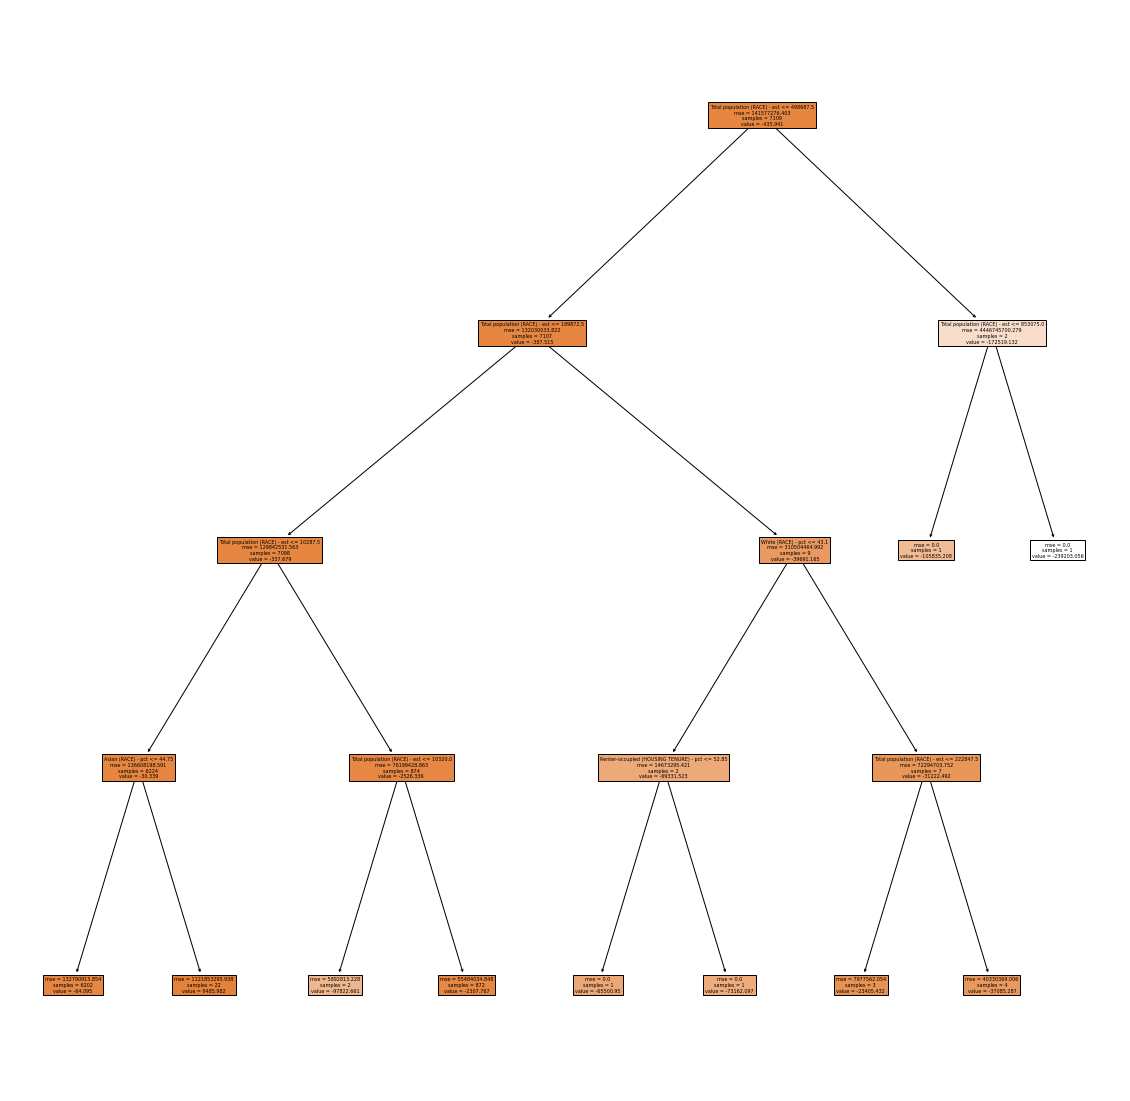

In [27]:
plt.rcParams['figure.figsize'] = [20, 20]
plot_tree(
    dt,
    feature_names = features,
    filled=True
)
plt.show()

## Plot for just (2.52, 0.0)-DP

In [18]:
grants = calc_total(funding(saipe, SonnenbergAuthorizer, Laplace(saipe, 2.52, 0), get_sppe("../data/sppe18.xlsx"), weighting))
grants_gaus = calc_total(funding(saipe, SonnenbergAuthorizer, Gaussian(saipe, 2.52, 0.2), get_sppe("../data/sppe18.xlsx"), weighting))
error = grants.true_grant_total/sum(grants.true_grant_total) - grants.est_grant_total/sum(grants.est_grant_total)
error_gaus = grants_gaus.true_grant_total/sum(grants_gaus.true_grant_total) - grants_gaus.est_grant_total/sum(grants_gaus.est_grant_total)

[WARN] Dropping districts with missing SPPE data: ['Puerto Rico']
[WARN] Dropping districts with missing SPPE data: ['Puerto Rico']


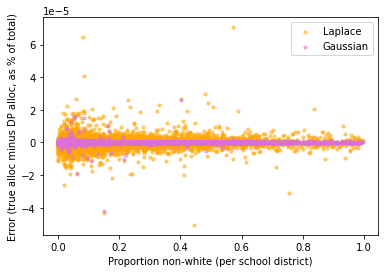

In [241]:
grants['prop_nonwhitealone'] = 1 - grants.race_2est / grants.race_1est
grants.prop_nonwhitealone[saipe.prop_nonwhitealone.isna()] = 0

plt.scatter(grants.prop_nonwhitealone, error, s=10, alpha=0.5, color='orange', label="Laplace")
plt.scatter(grants.prop_nonwhitealone, error_gaus, s=10, alpha=0.5, color='orchid', label="Gaussian")
ax = plt.gca()
ax.legend()
plt.xlabel("Proportion non-white (per school district)")
plt.ylabel("Error (true alloc minus DP alloc, as % of total)")
plt.show()